In [90]:
import joblib
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from bayes_opt import BayesianOptimization
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, make_scorer


pd.set_option('display.max_columns', 50)

## Data-Driven Predictions for Term Deposit Subscriptions

### 1. Introduction 

#### 1.1. Business context

Marketing campaigns are essential for businesses to promote products and services, but their success largely depends on targeting the right audience. One of the main challenges faced by banks is determining which customers are most likely to subscribe to a term deposit, especially during direct marketing campaigns. Misallocating resources can lead to wasted marketing efforts and missed opportunities for conversions, directly impacting the bank's revenue. Predicting customer behaviour in response to marketing can help banks optimise their campaigns, improve customer targeting, and increase their overall conversion rates.

#### 1.2. Objectives

By leveraging machine learning, we aim to predict whether a customer will subscribe to a term deposit after a marketing call. Accurately predicting such responses can provide several benefits: banks can reduce marketing costs by focusing on high-potential customers, personalise campaigns to improve customer satisfaction, and increase the overall effectiveness of their outreach strategies. Moreover, understanding the key factors that influence a customer’s decision can provide valuable insights for future marketing strategies.

In this project, we will build a subscription prediction model using the [Bank Marketing Dataset from the UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/222/bank+marketing). We will experiment with multiple classification algorithms, including Logistic Regression, Decision Trees, Random Forests, Gradient Boosting, Naive Bayes, and Neural Networks. After training and tuning these models, we will evaluate their performance using metrics like accuracy, precision, recall, and the area under the ROC curve (AUC-ROC). Finally, the best-performing model will be saved for future use, demonstrating how machine learning can enhance marketing strategies by predicting customer responses more effectively.

### 2. Data

#### 2.1. Dataset overview 

The [Bank Marketing Dataset](https://archive.ics.uci.edu/dataset/222/bank+marketing), provided by the UCI Machine Learning Repository, contains data from direct marketing campaigns carried out by a Portuguese banking institution. These campaigns primarily involved contacting customers through phone calls to promote term deposits. The dataset is designed to predict whether a customer will subscribe to a term deposit after the call, which is represented as a binary classification problem (`yes` or `no`).

The dataset consists of 20 attributes, including both categorical and numerical features that capture customer demographics, socio-economic conditions, and details of the marketing campaign itself. Below is an overview of some key attributes:


| Attribute | Description |
|-----------|-------------|
| age       | Age of the customer |
| job       | Type of job the customer holds (e.g., admin., blue-collar, technician) |
| marital   | Customer's marital status (single, married, divorced) |
| education | Level of education of the customer |
| default   | Indicates whether the customer has credit in default (yes or no) |
| balance   | The average yearly balance of the customer’s account (in euros) |
| housing   | Indicates whether the customer has a housing loan (yes or no) |
| loan      | Indicates whether the customer has a personal loan (yes or no) |
| contact   | Indicates whether the customer has a personal loan (yes or no) |
| day       | Last contact day of the month |
| month     | Last contact month of the year |
| duration  | Duration of the last call (in seconds) |
| campaign  | Number of contacts performed during this campaign for this client |
| pdays     | Number of days since the client was last contacted from a previous campaign |
| previous  | Number of contacts performed before this campaign |
| poutcome  | Outcome of the previous marketing campaign (e.g., success, failure) |
| y         | The target variable indicating whether the client subscribed to a term deposit (yes or no) |


This dataset offers a rich set of features that reflect both personal characteristics and previous interactions with the bank, providing an ideal foundation for machine learning models. The goal is to use these features to predict whether a client will subscribe to a term deposit, offering valuable insights for future marketing strategies.

#### 2.2. Data load 

To begin our analysis, we first need to load the dataset which can be imported directly from the [UC Irvine Machine Learning Repository Python package](https://github.com/uci-ml-repo/ucimlrepo).

In [3]:
bank_marketing = fetch_ucirepo(id=222) 

# Load the data as pandas dataframes
X = bank_marketing.data.features 
y = bank_marketing.data.targets 

In [4]:
print(X.shape[0], 'rows')
X.head()

45211 rows


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN


In [5]:
assert X.shape[0] == y.shape[0]
y.head()

,y
0,no
1,no
2,no
3,no
4,no


#### 2.3. Remove duplications 

We check for duplicates to identify and remove redundant entries. Duplicate rows can skew analysis and modeling by giving extra weight to repeated observations, leading to biased or inaccurate results.

In [6]:
X[X.duplicated()]

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome


By identifying and removing duplicates, we maintain the dataset's integrity, improving the reliability and accuracy of any models built on it. Fortunately, our dataset contains only unique rows.

#### 2.4. Data summary 

After an initial review of the data, it's essential to understand its structure and summary. This includes examining data types, identifying any missing values, and reviewing basic statistics for numerical features. Any missing values must be addressed before training the models.

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
dtypes: int64(7), object(9)
memory usage: 5.5+ MB


Although the dataset is mostly complete, columns such as `job`, `education`, `contact`, and especially `poutcome` have notable missing data which might require special handling (imputation or removal) later, depending on our modelling needs.

- `job` has missing 288 entries.
- `education` has missing 1,857 entries.
- `contact` has missing 12,020 entries.
- `poutcome` has missing 36,959 entries.

Most of the other features (such as `age`, `marital`, `balance`, etc.) have no missing values and contain data for all 45,211 entries.

The categorical features, such as `job`, `marital`, `education`, and others, will likely require encoding before being used in machine learning models.

Finally, the dataset requires approximately 5.5 MB of memory, which is manageable but may still benefit from optimisation, especially if/when working with limited computing resources.

### 3. Exploratory data analysis (EDA) 

To gain insights into the dataset, we will perform some initial data exploration, including visualising the distribution of key numerical features and the target variable to gain insights.

#### 3.1. Subscription distribution

In [8]:
merged_df = pd.concat([X, y], axis=1)
merged_df = merged_df.rename(columns={'y': 'subscription'})
merged_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,subscription
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In this section, we analyse the distribution of our target variable `subscription` to understand the balance between positive and negative outcomes. By visualising the frequency of each category, we can assess any class imbalance, which may guide our approach in the subsequent analysis.

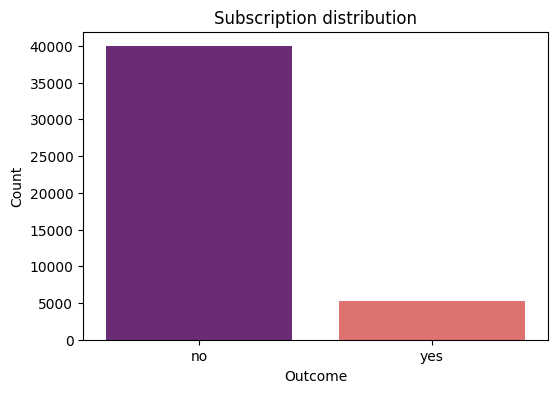

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x='subscription', data=merged_df, hue='subscription', palette="magma")
plt.title('Subscription distribution')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show();

In [10]:
subscription_rate = merged_df['subscription'].value_counts(normalize=True)['yes'] * 100
print(f"The subscription rate is {subscription_rate:.2f}%")

The subscription rate is 11.70%


#### 3.2. Distribution of selected predictors

We'll take a look at the distribution of `age`, `balance`, `duration` and `campaign`.

In [11]:
sns.set(style="whitegrid")

##### Age

The `age` predictor reflects the client's age, which is important because different age groups may respond differently to marketing campaigns and financial products.

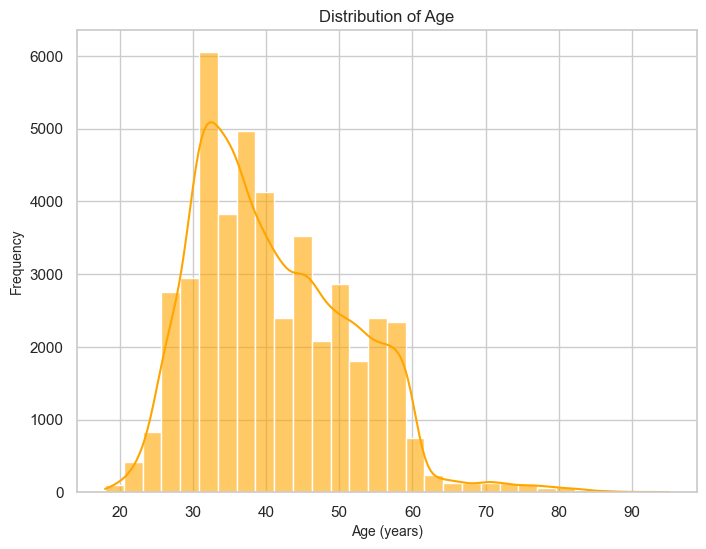

In [12]:
plt.figure(figsize=(8, 6))
sns.histplot(merged_df['age'], kde=True, color='orange', bins=30, alpha=0.6)
plt.title('Distribution of Age', fontsize=12)
plt.xlabel('Age (years)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show();

The distribution of this predictor is predominately right-skewed, with most observations concentrated between the ages of 30 and 40. There is a sharp decline in frequency after the age of 50, and very few individuals are over 60. This suggests that the dataset primarily targets younger to middle-aged individuals for the marketing campaign.

##### Balance

The `balance` predictor shows the average account balance, indicating a customer's financial standing, which could influence their likelihood of subscribing to a product, as those with higher balances may have different financial needs and behaviors.

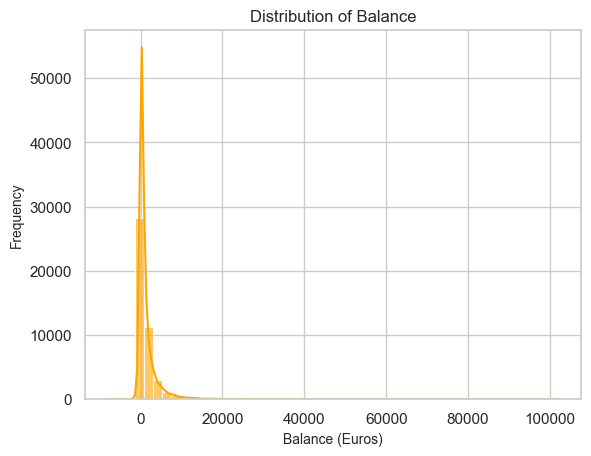

In [13]:
sns.histplot(merged_df['balance'], kde=True, color='orange', bins=50, alpha=0.6)
plt.title('Distribution of Balance', fontsize=12)
plt.xlabel('Balance (Euros)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show();

The distribution is heavily right-skewed, with a majority of individuals having low or even negative account balances. The highest frequencies are concentrated around zero, indicating that many customers have little to no balance in their accounts. There is a long tail extending towards higher balances, showing that a small portion of clients has significantly larger savings. This imbalance could suggest that a relatively small number of wealthy customers may disproportionately influence certain financial outcomes in the dataset.

##### Duration

The predictor `duration` represents the length of the last contact in seconds. It could be a critical predictor because longer conversations typically indicate greater engagement, which might be a strong indicator of the success or failure of a marketing campaign.

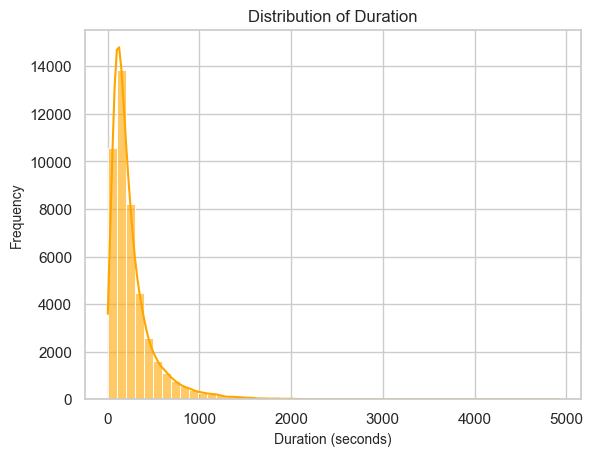

In [14]:
sns.histplot(merged_df['duration'], kde=True, color='orange', bins=50, alpha=0.6)
plt.title('Distribution of Duration', fontsize=12)
plt.xlabel('Duration (seconds)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show();

The distribution is also right-skewed, with most contacts lasting for a relatively short period. A significant portion of the calls lasts less than 300 seconds (5 minutes), with fewer contacts extending beyond this range. However, there is a noticeable long tail indicating that some calls last much longer, which may be associated with greater engagement and a higher likelihood of subscription.

##### Campaign

This variable shows the number of contacts made during the current marketing campaign for each individual. It's important to analyse because it can reflect persistence in marketing efforts.

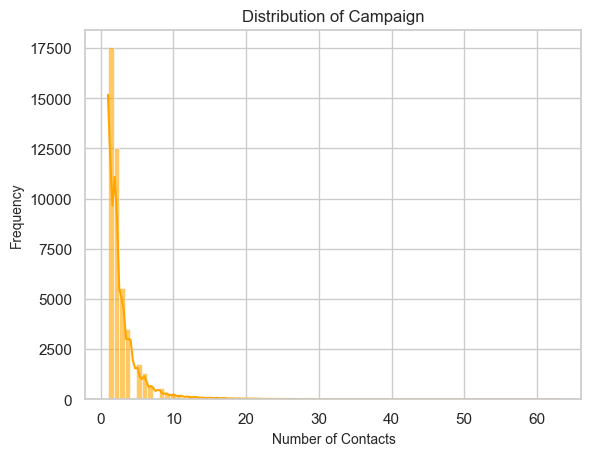

In [15]:
sns.histplot(merged_df['campaign'], kde=True, color='orange', bins=80, alpha=0.6)
plt.title('Distribution of Campaign', fontsize=12)
plt.xlabel('Number of Contacts', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show();

The distribution of this variable is heavily right-skewed. Most individuals have been contacted only once or twice, while very few have been contacted multiple times, with a small number of outliers receiving more than 10 contacts. This suggests that the marketing strategy tends to focus on fewer contact attempts for most customers, with persistent follow-ups being relatively rare.

#### 3.3. Correlation analysis <a name="subparagraph9"></a>

Understanding the correlation between numerical features helps identify potential multicollinearity issues and understand relationships between features.

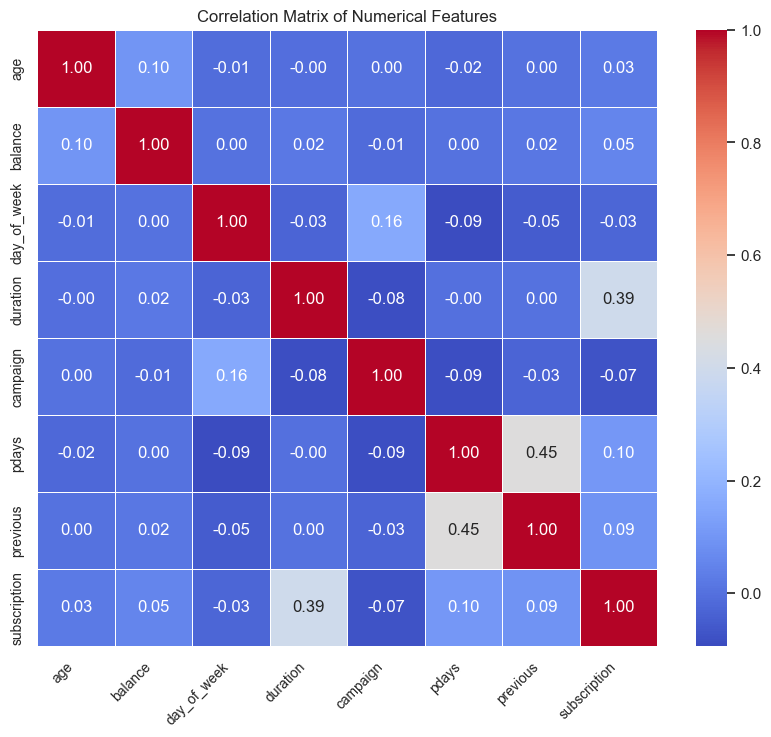

In [16]:
merged_df['subscription'] = merged_df['subscription'].map({'yes': 1, 'no': 0})
numerical_features = merged_df.select_dtypes(include=[np.number])
correlation_matrix = numerical_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix of Numerical Features', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show();

Notably, the `duration` feature has the strongest positive correlation with the subscription outcome, suggesting that longer contact durations increase the likelihood of subscription. Additionally, there is a moderate positive correlation between `pdays` (number of days since the client was last contacted) and `previous` (the number of previous contacts), indicating that clients who were contacted recently tend to have a higher number of previous contacts. 

Other numerical features, such as `age`, `balance`, and `campaign`, show little to no correlation with each other or the target variable, suggesting that they provide distinct, non-redundant information to the model. This analysis confirms that multicollinearity is not a significant concern, with `duration` emerging as a key predictor for the subscription outcome.

#### 3.4. Relationship between features and the target variable <a name="subparagraph10"></a>

We can also explore how certain features relate to the target variable. For example, examining the relationship between `duration` and `balance`, or `previous (contact)` and `subscription`.

##### Duration

Clients who subscribed tend to have significantly longer call durations, with the median and interquartile range for this group being higher than for those who did not subscribe. This indicates that longer, more engaged conversations are strongly associated with a positive subscription outcome. The spread of the data for the non-subscribers shows that most calls were much shorter, highlighting that brief calls may be less effective in driving subscriptions. This analysis further supports the earlier correlation finding, suggesting that duration is a key predictor of subscription success. 

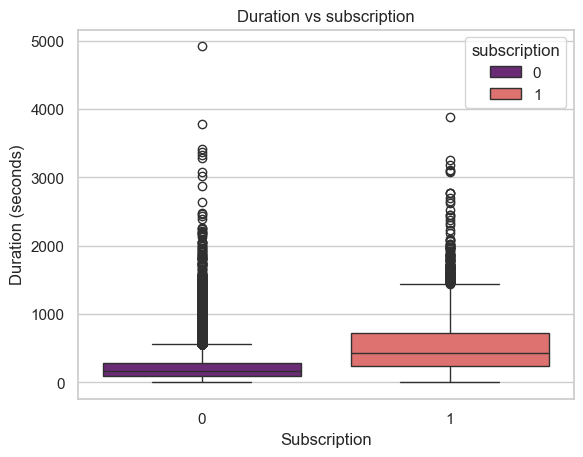

In [17]:
sns.boxplot(x='subscription', y='duration', data=merged_df, hue='subscription', palette='magma')
plt.title('Duration vs subscription')
plt.xlabel('Subscription')
plt.ylabel('Duration (seconds)')
plt.show();

##### Balance

The relationship between account balance and subscription is not very pronounced. Clients who subscribed generally tend to have slightly higher account balances, as indicated by the slightly elevated median balance compared to non-subscribers. However, the overall distribution of balances for both groups is quite similar, with significant overlap in the interquartile ranges. This suggests that while higher balances may have some influence on the likelihood of subscription, it is not a strong differentiator, and other factors such as call duration or previous contact history might play a more critical role in determining the outcome.

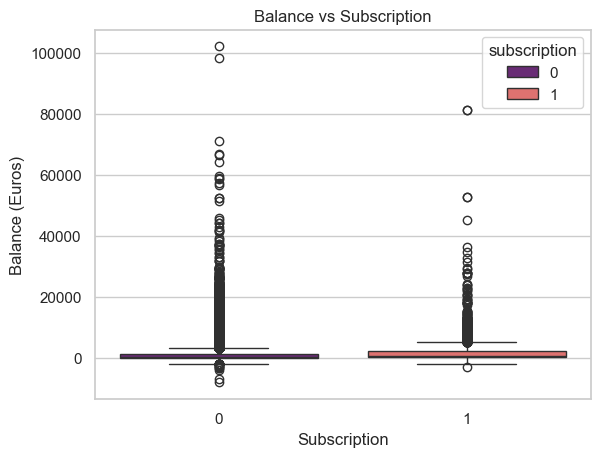

In [18]:
sns.boxplot(x='subscription', y='balance', data=merged_df, hue='subscription', palette='magma')
plt.title('Balance vs Subscription')
plt.xlabel('Subscription')
plt.ylabel('Balance (Euros)')
plt.show()

##### Previous contact

The log scale compresses the higher values, reducing the skewness caused by outliers and allowing for a more balanced comparison between the groups. After applying the log transformation, we can see that clients who subscribed generally had a higher number of previous contacts compared to non-subscribers. 

Clients who subscribed generally have a higher number of previous contacts, as indicated by the greater median and interquartile range for this group. This suggests that repeated interactions with the client increase the likelihood of subscription. Non-subscribers, on the other hand, tend to have fewer previous contacts, indicating that limited engagement might result in a lower likelihood of subscription. This trend highlights the importance of follow-up efforts and suggests that clients who have been contacted multiple times in previous campaigns may be more inclined to subscribe.

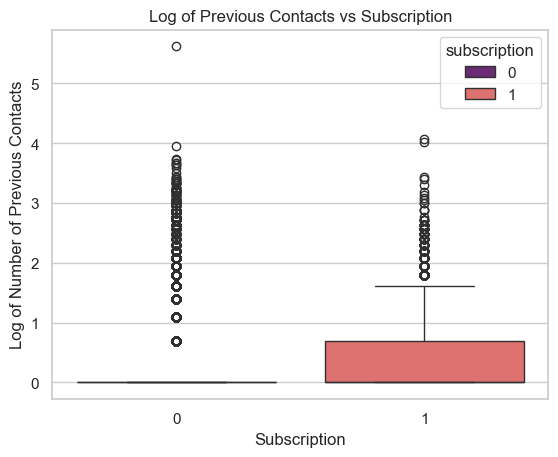

In [19]:
merged_df_copy = merged_df.copy()
merged_df_copy['previous_log'] = np.log1p(merged_df_copy['previous'])
sns.boxplot(x='subscription', y='previous_log', data=merged_df_copy, hue='subscription', palette='magma')
plt.title('Log of Previous Contacts vs Subscription')
plt.xlabel('Subscription')
plt.ylabel('Log of Number of Previous Contacts')
plt.show();

##### Categorical and boolen features

Now, we are going to use stacked bar plots to visualise how different categorical features relate to subscription. Each bar in the plots represents a category, with segments showing the proportion of subscription (red for no and pink for yes). This helps us identify which features may be strong indicators of subscription, guiding our subsequent strategies for improving subscription conversion.

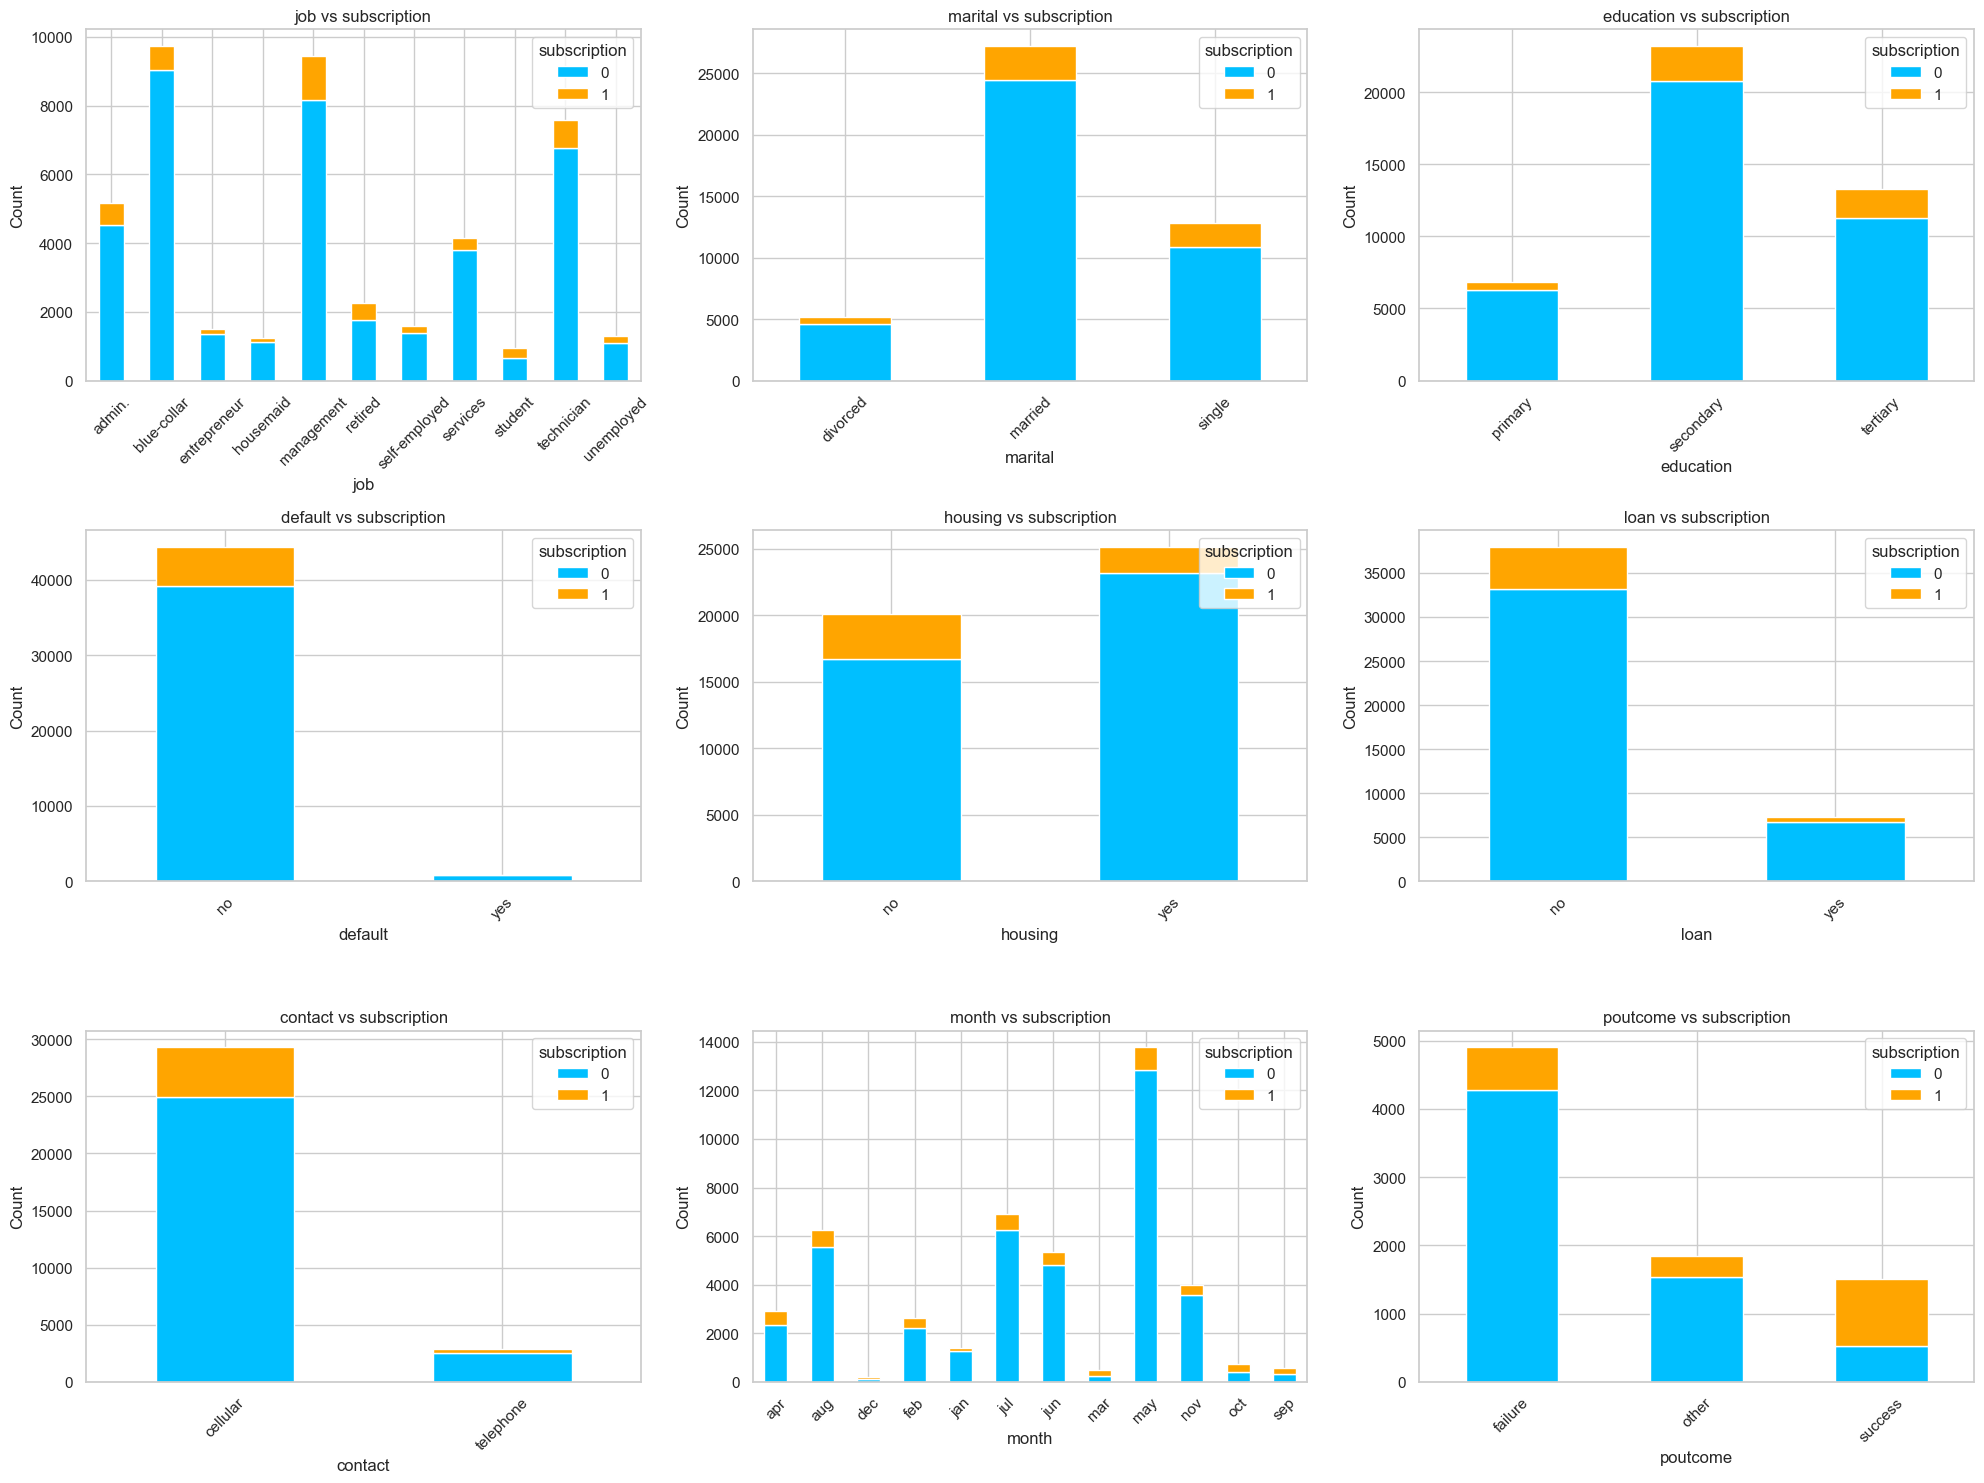

In [20]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

palette = {0: 'deepskyblue', 1: 'orange'}

n_cols = 3
n_rows = (len(categorical_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
fig.subplots_adjust(hspace=0.6, wspace=0.6)
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    temp_df = merged_df.groupby([feature, 'subscription']).size().unstack().fillna(0)
    
    temp_df.plot(kind='bar', stacked=True, color=palette, ax=axes[i])
    axes[i].set_title(f'{feature} vs subscription')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel(feature)
    axes[i].legend(title='subscription', loc='upper right')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show();

These plots help us visually inspect how weak or strong a predictor of subscription each feature is:

- **Job**: certain professions, such as "management" and "blue-collar" workers, show relatively lower subscription rates, while others like "students" and "retired" clients have a noticeably higher subscription rate. This suggests that occupation might be a relevant indicator of subscription behavior.

- **Marital Status**: the subscription rates appear relatively similar across "married," "single," and "divorced" clients, indicating that marital status alone may not be a strong predictor of subscription.

- **Education**: clients with "tertiary" education tend to subscribe more compared to those with "secondary" or "primary" education. This suggests that higher education levels may be associated with an increased likelihood of subscribing to the bank's product.

- **Default**: clients with a "no" default status (those who do not have credit in default) are more likely to subscribe than those with a "yes" default status. This makes sense, as clients without financial difficulties may be more open to engaging with additional financial products.

- **Housing**: clients without a housing loan appear more likely to subscribe compared to those with a housing loan, although the difference is not substantial.

- **Loan**: similar to the housing loan, clients without personal loans show a slightly higher subscription rate than those with personal loans. This suggests that clients not already in debt might be more inclined to subscribe to additional services.

- **Contact**: clients contacted via "cellular" are much more likely to subscribe compared to those contacted through "telephone."

- **Month**: the month in which a client is contacted plays a role, with higher subscription rates observed in months like "March" and "December," and lower rates in "September." This suggests that seasonal trends may influence client subscription behavior.

- **Poutcome** (Outcome of Previous Campaign): clients who had a "success" in a previous campaign are much more likely to subscribe again. This highlights the importance of previous interactions, as a successful outcome in the past makes clients more open to engaging with the bank again.

These insights provide a clearer understanding of how each categorical feature influences the likelihood of subscription, which will guide feature selection and interpretation in later modeling stages.

### 4. Data pre-processing 

In [21]:
df = merged_df.copy()

#### 4.1. Convert binary columns to booleans 

We choose to convert 0/1 columns to boolean types for both memory efficiency (especially useful with large datasets) and improved clarity, as it clearly indicates that these columns represent binary or categorical data.

Although 0 and 1 can indicate binary states, they may also be mistakenly treated as numeric values, leading to incorrect assumptions or operations. Additionally, boolean columns are more appropriate for logical operations like `AND`, `OR`, and `NOT`, making the code easier to read and reducing the likelihood of errors.

In [22]:
binary_columns = []
for col in df.columns:
    if len(pd.unique(df[col])) == 2:
        binary_columns.append(col)

df[binary_columns].head()

,default,housing,loan,subscription
0,no,yes,no,0
1,no,yes,no,0
2,no,yes,yes,0
3,no,yes,no,0
4,no,no,no,0


In [23]:
# Convert yes/no columns to bool
yn_cols = ['default', 'housing', 'loan']
                 
for col in yn_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0}).astype('bool')

In [24]:
# Convert target variable (0/1) to bool
df['subscription'] = df['subscription'].astype('bool')

In [25]:
df[binary_columns].head()

,default,housing,loan,subscription
0,True,True,True,False
1,True,True,True,False
2,True,True,True,False
3,True,True,True,False
4,True,True,True,False


#### 4.2. Apply one-hot encoding to categorical variables

Now that we've processed the binary columns, we will apply one-hot encoding to the remaining categorical variables. This step converts categorical features into a numerical format, making them suitable for use by machine learning algorithms.

In [26]:
categorical_columns = []
for col in df.columns:
    if (len(pd.unique(df[col])) > 2) and (df[col].dtype == 'object'):
        categorical_columns.append(col)

df[categorical_columns].head()

,job,marital,education,contact,month,poutcome
0,management,married,tertiary,NaN,may,NaN
1,technician,single,secondary,NaN,may,NaN
2,entrepreneur,married,secondary,NaN,may,NaN
3,blue-collar,married,NaN,NaN,may,NaN
4,NaN,single,NaN,NaN,may,NaN


First, we fill the NaN values with 'Unknown' because missing data in the categorical features might carry important information, such as unrecorded or unavailable data, that could affect the model's predictions. By creating a separate 'Unknown' category, we preserve the data and allow the model to learn from these potentially meaningful patterns.

In [27]:
df[categorical_columns] = df[categorical_columns].fillna('Unknown')

The `get_dummies` method in pandas converts categorical variables into separate binary columns for each category. By using the `drop_first=True` argument, we drop the first category from each variable, which helps avoid multicollinearity and eliminates redundancy in the dataset.

In [28]:
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [29]:
df.columns = [col.replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_').lower() for col in df.columns]
df.head()

,age,default,balance,housing,loan,day_of_week,duration,campaign,pdays,previous,subscription,job_admin.,job_blue_collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self_employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_primary,education_secondary,education_tertiary,contact_cellular,contact_telephone,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success
0,58,True,2143,True,True,5,261,1,-1,0,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,44,True,29,True,True,5,151,1,-1,0,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,33,True,2,True,True,5,76,1,-1,0,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
3,47,True,1506,True,True,5,92,1,-1,0,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
4,33,True,1,True,True,5,198,1,-1,0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False


#### 4.3. Split up the dataset into training and test sets 

We split the data into training and testing sets after further pre-processing to prevent data leakage, ensuring that the model doesn't gain insights from the test set during training. This step also ensures that the pre-processing steps are applied consistently across both sets, preserving the integrity and generalizability of the model's performance. 

In [30]:
X = df.drop(['subscription'], axis=1)
y = df['subscription']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (31647, 42) (31647,)
Testing set: (13564, 42) (13564,)


In [31]:
X_train = X_train.copy() 
X_test = X_test.copy()
y_train = y_train.copy()
y_test = y_test.copy()

#### 4.4. Feature scaling

Feature scaling ensures that all numerical features have equal influence during model training, which is especially important for algorithms that use distance calculations, as features with larger ranges could otherwise dominate the results. Other than that, scaling can speed up the convergence of gradient-based optimization algorithms, such as those used in neural networks and linear regression.

In [32]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols].head()

,age,balance,day_of_week,duration,campaign,pdays,previous
0,58,2143,5,261,1,-1,0
1,44,29,5,151,1,-1,0
2,33,2,5,76,1,-1,0
3,47,1506,5,92,1,-1,0
4,33,1,5,198,1,-1,0


Numerical features that have a meaningful order (like ordinal variables) won't be scaled. This is because the differences between consecutive values in these variables carry important information that scaling could distort. 

The variable `pdays` has special values like -1, which indicate no prior contact, and scaling would interfere with this important interpretation. Similarly, `day_of_week` should not be scaled because it represents categorical information (the day a client was contacted).

In [33]:
numerical_cols = numerical_cols.drop(['day_of_week', 'pdays'])

scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.fit_transform(X_test[numerical_cols])

In [34]:
X_train[numerical_cols].head()

,age,balance,duration,campaign,previous
42867,1.134306,1.668865,-0.195753,-0.565386,-0.233744
27173,0.851654,-0.370196,0.533532,-0.246459,-0.233744
8875,-0.184737,-0.277891,1.347708,-0.246459,-0.233744
18330,0.097915,-0.240583,0.741899,-0.246459,-0.233744
8306,1.605393,0.071386,0.383045,0.072468,-0.233744


In [35]:
X_test[numerical_cols].head()

,age,balance,duration,campaign,previous
6016,0.199538,-0.300604,-0.547320,1.082595,-0.31127
23977,0.669912,0.203202,-0.929708,1.082595,-0.31127
23227,0.669912,-0.421795,-0.436940,0.417815,-0.31127
11884,0.858062,0.517951,-0.945477,11.386677,-0.31127
10082,0.858062,-0.455728,2.598510,-0.579354,-0.31127


#### 4.5. Inspect the pre-processed data structure 

Let's see how the summary of our dataset has changed.

In [36]:
assert (X_train.dtypes == X_test.dtypes).all()
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31647 entries, 42867 to 35683
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  31647 non-null  float64
 1   default              31647 non-null  bool   
 2   balance              31647 non-null  float64
 3   housing              31647 non-null  bool   
 4   loan                 31647 non-null  bool   
 5   day_of_week          31647 non-null  int64  
 6   duration             31647 non-null  float64
 7   campaign             31647 non-null  float64
 8   pdays                31647 non-null  int64  
 9   previous             31647 non-null  float64
 10  job_admin.           31647 non-null  bool   
 11  job_blue_collar      31647 non-null  bool   
 12  job_entrepreneur     31647 non-null  bool   
 13  job_housemaid        31647 non-null  bool   
 14  job_management       31647 non-null  bool   
 15  job_retired          31647 non-null  

The `describe` method generates summary statistics for numerical features, including count, mean, standard deviation, and percentiles. This offers a quick overview of the central tendency and variability within the dataset.

In [37]:
X_train.describe()

,age,balance,day_of_week,duration,campaign,pdays,previous
count,3.164700e+04,3.164700e+04,31647.000000,3.164700e+04,3.164700e+04,31647.000000,3.164700e+04
mean,-1.266300e-16,1.796171e-17,15.822005,9.070663e-17,3.367820e-17,39.980188,3.906672e-17
std,1.000016e+00,1.000016e+00,8.312910,1.000016e+00,1.000016e+00,100.015520,1.000016e+00
min,-2.163302e+00,-3.023548e+00,1.000000,-9.983523e-01,-5.653864e-01,-1.000000,-2.337437e-01
25%,-7.500415e-01,-4.206898e-01,8.000000,-6.009112e-01,-5.653864e-01,-1.000000,-2.337437e-01
50%,-1.847372e-01,-2.987964e-01,16.000000,-3.037951e-01,-2.464590e-01,-1.000000,-2.337437e-01
75%,6.632193e-01,2.057068e-02,21.000000,2.364160e-01,7.246838e-02,-1.000000,-2.337437e-01
max,5.091437e+00,3.240143e+01,31.000000,1.797849e+01,1.920811e+01,871.000000,1.121436e+02


In [38]:
X_test.describe()

,age,balance,day_of_week,duration,campaign,pdays,previous
count,1.356400e+04,1.356400e+04,13564.000000,1.356400e+04,1.356400e+04,13564.000000,1.356400e+04
mean,-9.953046e-17,4.190756e-18,15.770053,-8.695819e-17,5.055100e-17,40.705618,-3.928834e-17
std,1.000037e+00,1.000037e+00,8.344946,1.000037e+00,1.000037e+00,100.394282,1.000037e+00
min,-2.152334e+00,-1.245890e+00,1.000000,-1.012493e+00,-5.793540e-01,-1.000000,-3.112704e-01
25%,-7.412107e-01,-4.314901e-01,8.000000,-6.064523e-01,-5.793540e-01,-1.000000,-3.112704e-01
50%,-1.767614e-01,-3.040669e-01,16.000000,-3.029073e-01,-2.469643e-01,-1.000000,-3.112704e-01
75%,6.699124e-01,2.427271e-02,21.000000,2.371662e-01,8.542544e-02,-1.000000,-3.112704e-01
max,5.091431e+00,2.766185e+01,31.000000,1.208330e+01,1.570774e+01,842.000000,1.941076e+01


In [39]:
y_train.value_counts()

subscription
False    27957
True      3690
Name: count, dtype: int64

### 5. Model experimentation 

#### 5.1. Introduction 

In this section, we will explore various models for binary classification, including Logistic Regression, Random Forests, Gradient Boosting, XGBoost and Neural Networks. Our objective is to predict whether a customer will subscribe to a term deposit after a marketing call, using the predictors we've analysed in the previous sections. 

In the next section, we will dive deeper into model evaluation, where we will use various performance metrics to quantify and compare the quality of our predictions. When selecting an algorithm, other than performance metrics, we will also consider factors like data complexity, model interpretability, available computational resources, and the specific needs of the task. For now, due to the imbalanced nature of our dataset, we will evaluate our model performance using the ROC score, plot the ROC-AUC curves, and analyzs the results with a confusion matrix.

The ROC (Receiver Operating Characteristic) score, often measured as the AUC (Area Under the Curve), evaluates the model's ability to distinguish between positive and negative classes across all possible classification thresholds. In imbalanced datasets like this one, where the number of non-subscribers far outweighs subscribers, accuracy can be misleading as a model could achieve high accuracy simply by predicting the majority class. The ROC-AUC score, however, focuses on the model's performance in correctly identifying both classes, making it a more reliable metric for evaluating imbalanced datasets.

In [40]:
def roc_auc(y_test, y_pred):
    ra = roc_auc_score(y_test, y_pred)
    return round(ra*100, 2)

The confusion matrix shows the true positives, true negatives, false positives, and false negatives, providing a clearer picture of how well the model performs on each class. It helps us visualise the exact number of correct and incorrect predictions for each class.

In [41]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show();

The ROC-AUC curve helps us visualise a model's performance across different classification thresholds, giving a clear picture of how well it distinguishes between classes and making it easy to compare multiple models. It plots the true positive rate (sensitivity) against the false positive rate (1 - specificity) at various thresholds. 

The AUC (Area Under the Curve) provides a single score representing the model's overall ability to differentiate between positive and negative classes, with a higher AUC indicating better performance. We will use the `plot_roc_curve` function to consistently generate these plots across all model evaluations.

In [42]:
def plot_roc_curve(y_test, y_pred_prob, model_name):
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='deepskyblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='m', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

Finally, the `performance` function takes the true and predicted labels for a model and returns the performance measures: accuracy, precision, recall, and F1 score. 

- **roc_auc_score**: measures the area under the ROC curve, reflecting the model's ability to distinguish between positive and negative classes across various threshold settings.
- **accuracy_score**: measures the ratio of correctly predicted instances to the total instances.
- **precision_score**: measures the ratio of correctly predicted positive observations to the total predicted positives.
- **recall_score**: measures the ratio of correctly predicted positive observations to all observations in the actual class.
- **f1_score**: the harmonic mean of precision and recall, providing a balance between the two.

In [43]:
def performance(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    ps = precision_score(y_true, y_pred, average='weighted')
    rs = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    ra = roc_auc_score(y_true, y_pred)
    performance = {
        'Algorithm': model_name,
        'ROC-AUC Score': round(ra*100, 2),
        'Accuracy': round(acc*100, 2),
        'Precision': round(ps*100, 2),
        'Recall': round(rs*100, 2),
        'F1 Score': round(f1*100, 2)
    }
    return performance

#### 5.2. Logistic Regression 

Logistic Regression is commonly used as a baseline model for binary classification tasks due to its simplicity and interpretability. It provides coefficients for each feature, showing the strength and direction of their relationship with the likelihood of the target outcome. If this algorithm is selected as the best model, its explainability can be highly valuable for businesses, helping them understand the key factors influencing customer decisions and enabling more informed, data-driven strategies.

ROC Score: 66.45%


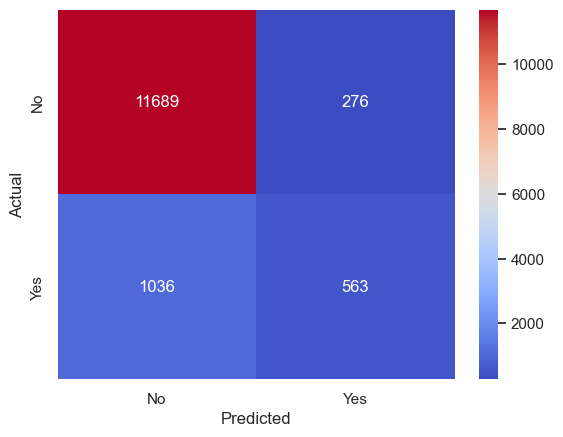

In [44]:
logreg = LogisticRegression(max_iter=5000, random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

print("ROC Score: {}%".format(roc_auc(y_test, y_pred_logreg)))
plot_confusion_matrix(y_test, y_pred_logreg);

The confusion matrix shows that there is a significant imbalance between the true positive and false negative predictions, indicating that the model is missing many "Yes" predictions. To address this, we will implement techniques to handle class imbalance to improve the model's performance in predicting the minority class.

First, we'll set the Logistic Regression parameter `class_weight` to `balanced`, which will automatically adjust the importance of classes based on their frequencies in the dataset. This approach is computationally lighter, does not alter the data and can give good results.

ROC Score: 82.71%


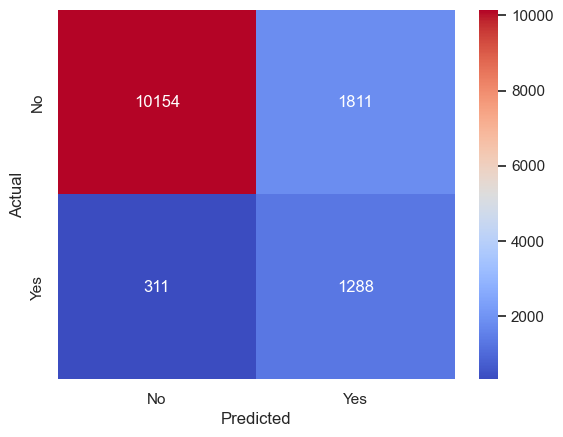

In [45]:
logreg_balanced = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
logreg_balanced.fit(X_train, y_train)
y_pred_logreg_balanced = logreg_balanced.predict(X_test)
y_pred_prob_logreg_balanced = logreg_balanced.predict_proba(X_test)[:, 1]

print("ROC Score: {}%".format(roc_auc(y_test, y_pred_logreg_balanced)))
plot_confusion_matrix(y_test, y_pred_logreg_balanced);

The updated confusion matrix shows significant improvement after applying `class_weight='balanced'`. The model is now correctly classifying a higher number of the "Yes" instances compared to the previous result, and the ROC score has increased. However, there are still a notable number of false negatives and false positives, indicating room for further improvement.

To attempt said performance improvement, we will explore two additional techniques: `SMOTE` and `RandomUnderSampler`. `SMOTE` aims to address class imbalance by generating synthetic samples of the minority class, thereby increasing its representation in the training data. This can help the model learn more about the minority class and potentially reduce the number of false negatives. On the other hand, `RandomUnderSampler` tackles class imbalance by reducing the number of samples in the majority class, which helps simplify the decision boundary and prevents the model from being biased toward the majority class.

ROC Score: 77.29%


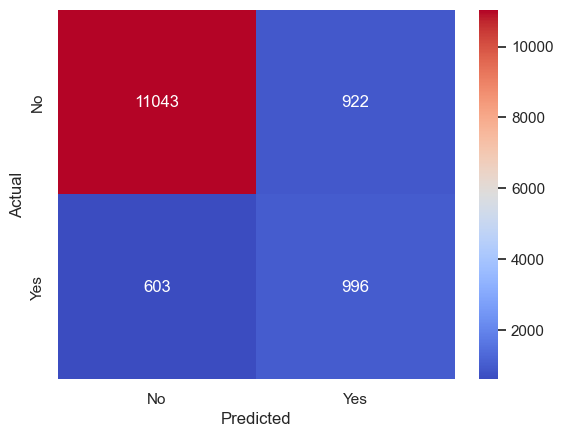

In [46]:
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

logreg_smote = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
logreg_smote.fit(X_train_res, y_train_res)
y_pred_logreg_smote = logreg_smote.predict(X_test)
y_pred_prob_logreg_smote = logreg_smote.predict_proba(X_test)[:, 1]

print("ROC Score: {}%".format(roc_auc(y_test, y_pred_logreg_smote)))
plot_confusion_matrix(y_test, y_pred_logreg_smote);

ROC Score: 82.38%


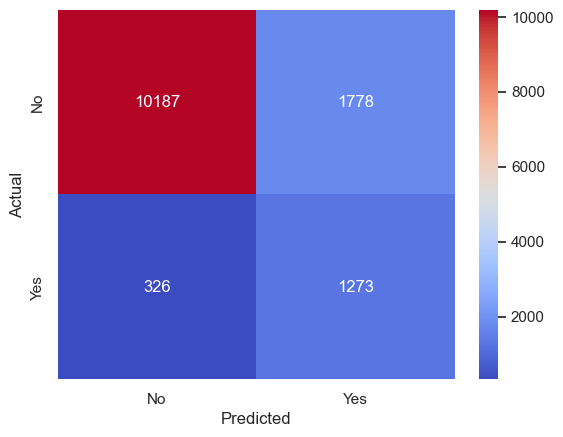

In [47]:
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

logreg_rs = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
logreg_rs.fit(X_train_res, y_train_res)
y_pred_logreg_rs = logreg_rs.predict(X_test)
y_pred_prob_logreg_rs = logreg.predict_proba(X_test)[:, 1]

print("ROC Score: {}%".format(roc_auc(y_test, y_pred_logreg_rs)))
plot_confusion_matrix(y_test, y_pred_logreg_rs);

Overall, the Logictic Regression native class weighting and the `RandomUnderSampler` approaches seemed to offer better performance, reducing false negatives and improving generalisation, though it comes at the cost of slightly more false positives.

Note that these are not our final models, as we will focus on fine-tuning hyperparameters in the next section.

#### 5.3. Hyperparameter tuning strategy

Hyperparameter tuning is a crucial step in optimising machine learning models to enhance their performance. Proper tuning can significantly improve a model's accuracy, robustness, and generalisability to new data.

We chose Bayesian Optimization to fine-tune the hyperparameters of our models because it efficiently explores the hyperparameter space by balancing the exploration of new areas and the exploitation of promising regions. This leads to faster convergence on optimal solutions. Unlike grid search or random search, Bayesian optimization is more sample-efficient, making it especially useful when model evaluation is computationally expensive or when we need to maximise performance metrics within a limited number of iterations.

First we define the function `optimise_log_reg` which defines how we evaluate the performance of the logistic regression model for given hyperparameters. Here, we're using cross-validation with the ROC-AUC score as the evaluation metric because it evaluates the model's ability to distinguish between the positive and negative classes, providing a more balanced performance measure than accuracy.

In [48]:
def optimise_log_reg(C, penalty):
    penalty = 'l1' if penalty < 0.5 else 'l2'
    model = LogisticRegression(
        C=C, 
        penalty=penalty, 
        solver='liblinear', 
        class_weight='balanced', 
        max_iter=5000, 
        random_state=42
    )
    scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=3)    
    return scores.mean()

We use the `BayesianOptimization` class to search the hyperparameter space, with the goal of maximizing the cross-validated ROC-AUC score.

In [49]:
param_space = {
    'C': (0.001, 10),  # Inverse regularization strength (0.001 to 10)
    'penalty': (0, 1)  # Binary choice for L1 ('l1') or L2 ('l2')
}

optimiser = BayesianOptimization(f=optimise_log_reg, pbounds=param_space, random_state=42, verbose=2)
optimiser.maximize(init_points=5, n_iter=10)
best_params = optimiser.max['params']
best_penalty = 'l1' if best_params['penalty'] < 0.5 else 'l2'
best_C = best_params['C']
print(f"Best C: {best_C}")
print(f"Best Penalty: {best_penalty}")

|   iter    |  target   |     C     |  penalty  |
-------------------------------------------------
| 1         | 0.9034    | 3.746     | 0.9507    |
| 2         | 0.9034    | 7.32      | 0.5987    |
| 3         | 0.9035    | 1.561     | 0.156     |
| 4         | 0.9035    | 0.5818    | 0.8662    |
| 5         | 0.9034    | 6.012     | 0.7081    |
| 6         | 0.8097    | 0.001     | 0.0       |
| 7         | 0.9034    | 7.905     | 0.1211    |
| 8         | 0.9034    | 7.426     | 0.1317    |
| 9         | 0.9034    | 1.52      | 1.0       |
| 10        | 0.9035    | 0.6329    | 0.8225    |
| 11        | 0.9034    | 4.756     | 0.0       |
| 12        | 0.9034    | 2.894     | 0.0       |
| 13        | 0.9033    | 9.456     | 1.0       |
| 14        | 0.9034    | 10.0      | 0.0       |
| 15        | 0.9034    | 4.926     | 1.0       |
Best C: 0.5817780380698264
Best Penalty: l2


Once the best hyperparameters are found, we retrain the Logistic Regression model using these optimal settings and evaluate its performance on the test set.

ROC Score: 82.73%


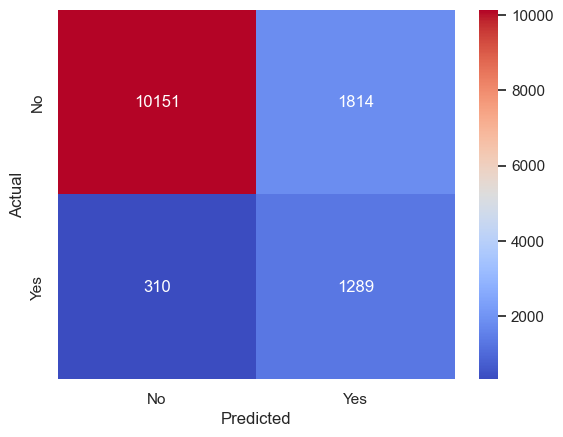

In [50]:
best_logreg = LogisticRegression(
    C=best_C, 
    penalty=best_penalty, 
    solver='liblinear', 
    class_weight='balanced', 
    max_iter=5000, 
    random_state=42
)

best_logreg.fit(X_train, y_train)
y_pred_best = best_logreg.predict(X_test)
y_pred_best_prob = best_logreg.predict_proba(X_test)[:, 1]

print("ROC Score: {}%".format(roc_auc(y_test, y_pred_best)))
plot_confusion_matrix(y_test, y_pred_best);

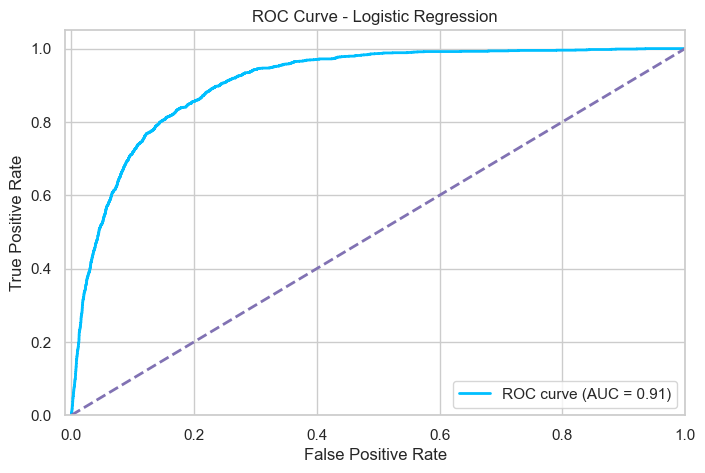

In [51]:
plot_roc_curve(
    y_test=y_test, 
    y_pred_prob=y_pred_best_prob, 
    model_name="Logistic Regression"
)

In [52]:
lr_performance = performance(
    y_true=y_test, 
    y_pred=y_pred_best, 
    model_name='Logistic Regression'
)

#### 5.4. Random Forest

The motivation to experiment with Random Forest stems from its ability to reduce overfitting and improve predictive performance by averaging the results of multiple decision trees. As an ensemble method, Random Forest is less sensitive to variations and noise in the dataset, making it more stable.

It is particularly robust to class imbalance, especially when using class weighting, and can capture complex interactions between features without needing extensive preprocessing, such as feature scaling. Random Forest generally performs well on structured data and provides valuable insights into feature importance, helping to identify the key factors driving customer subscriptions.

Note that from now on, we will always utilise Bayesian Optimisation to fine-tune the hyperparameters of the models we are experimenting with.

##### Class weighting

In [53]:
def optimise_random_forest(n_estimators, max_depth, min_samples_split, max_features):
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    max_features = float(max_features)
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        max_features=max_features,
        class_weight='balanced',
        random_state=42
    )
    scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=3)
    return scores.mean()

In [54]:
param_space = {
    'n_estimators': (100, 500),          # Number of trees in the forest
    'max_depth': (5, 30),                # Maximum depth of each tree
    'min_samples_split': (2, 20),        # Minimum samples required to split a node
    'max_features': (0.1, 1.0)           # Maximum number of features to consider for each split
}

optimiser = BayesianOptimization(f=optimise_random_forest, pbounds=param_space, random_state=42, verbose=2)
optimiser.maximize(init_points=5, n_iter=5)
best_params = optimiser.max['params']
best_n_estimators = int(best_params['n_estimators'])
best_max_depth = int(best_params['max_depth'])
best_min_samples_split = int(best_params['min_samples_split'])
best_max_features = float(best_params['max_features'])
print(f"Best Parameters: n_estimators={best_n_estimators}, max_depth={best_max_depth}, min_samples_split={best_min_samples_split}, max_features={best_max_features}")

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.9184    | 14.36     | 0.9556    | 15.18     | 339.5     |
| 2         | 0.9119    | 8.9       | 0.2404    | 3.046     | 446.5     |
| 3         | 0.9209    | 20.03     | 0.7373    | 2.371     | 488.0     |
| 4         | 0.9258    | 25.81     | 0.2911    | 5.273     | 173.4     |
| 5         | 0.9174    | 12.61     | 0.5723    | 9.775     | 216.5     |
| 6         | 0.9232    | 25.37     | 0.6699    | 5.601     | 174.1     |
| 7         | 0.9239    | 26.25     | 0.6129    | 3.979     | 171.6     |
| 8         | 0.9238    | 27.98     | 0.1       | 6.507     | 172.5     |
| 9         | 0.9224    | 27.93     | 0.1       | 3.494     | 174.3     |
| 10        | 0.9242    | 24.67     | 0.1       | 6.8       | 171.1     |
Best Parameters: n_estimators=173, max_depth=25, min_samples_split=5, max_features=0.29110519961044856


ROC Score: 73.28%


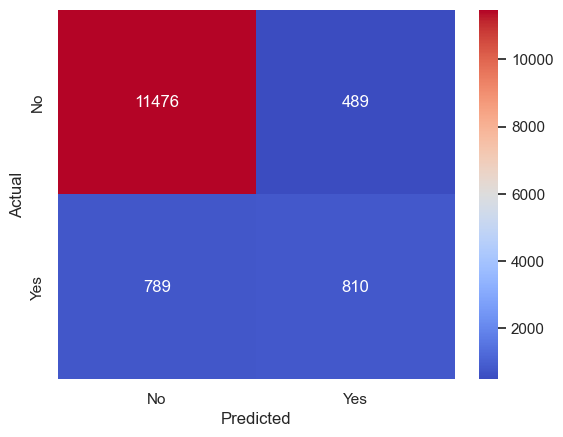

In [55]:
best_rf = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    max_features=best_max_features,
    class_weight='balanced',
    random_state=42
)


best_rf.fit(X_train, y_train)
y_pred_best_rf = best_rf.predict(X_test)
y_pred_best_prob_rf = best_rf.predict_proba(X_test)[:, 1]

print("ROC Score: {}%".format(roc_auc(y_test, y_pred_best_rf)))
plot_confusion_matrix(y_test, y_pred_best_rf);

In [56]:
rf_performance = performance(
    y_true=y_test, 
    y_pred=y_pred_best_rf, 
    model_name='Random Forest'
)

##### Random undersampling

In [57]:
def optimise_random_forest_rs(n_estimators, max_depth, min_samples_split, max_features):
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    max_features = float(max_features)
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        max_features=max_features,
        class_weight='balanced',
        random_state=42
    )
    scores = cross_val_score(model, X_train_res, y_train_res, scoring='roc_auc', cv=3)
    return scores.mean()

optimiser = BayesianOptimization(f=optimise_random_forest_rs, pbounds=param_space, random_state=42, verbose=2)
optimiser.maximize(init_points=5, n_iter=5)
best_params = optimiser.max['params']
best_n_estimators = int(best_params['n_estimators'])
best_max_depth = int(best_params['max_depth'])
best_min_samples_split = int(best_params['min_samples_split'])
best_max_features = float(best_params['max_features'])
print(f"Best Parameters: n_estimators={best_n_estimators}, max_depth={best_max_depth}, min_samples_split={best_min_samples_split}, max_features={best_max_features}")

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.9127    | 14.36     | 0.9556    | 15.18     | 339.5     |
| 2         | 0.9104    | 8.9       | 0.2404    | 3.046     | 446.5     |
| 3         | 0.9149    | 20.03     | 0.7373    | 2.371     | 488.0     |
| 4         | 0.9186    | 25.81     | 0.2911    | 5.273     | 173.4     |
| 5         | 0.9151    | 12.61     | 0.5723    | 9.775     | 216.5     |
| 6         | 0.9148    | 15.77     | 0.7536    | 14.48     | 181.8     |
| 7         | 0.9176    | 24.2      | 0.4495    | 6.81      | 173.1     |
| 8         | 0.9149    | 30.0      | 0.1       | 2.0       | 180.2     |
| 9         | 0.9149    | 27.64     | 0.1       | 2.919     | 168.6     |
| 10        | 0.9157    | 23.52     | 0.5303    | 2.927     | 175.6     |
Best Parameters: n_estimators=173, max_depth=25, min_samples_split=5, max_features=0.29110519961044856


ROC Score: 85.73%


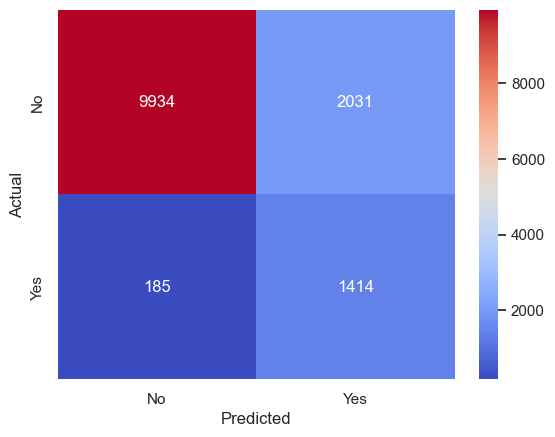

In [58]:
best_rf_rs = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    max_features=best_max_features,
    class_weight='balanced',
    random_state=42
)


best_rf_rs.fit(X_train_res, y_train_res)
y_pred_best_rf_rs = best_rf_rs.predict(X_test)
y_pred_best_prob_rf_rs = best_rf_rs.predict_proba(X_test)[:, 1]

print("ROC Score: {}%".format(roc_auc(y_test, y_pred_best_rf_rs)))
plot_confusion_matrix(y_test, y_pred_best_rf_rs);

##### Balanced random forest

In [59]:
def optimise_balanced_random_forest(n_estimators, max_depth, min_samples_split, max_features):
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    max_features = float(max_features)
    model = BalancedRandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        max_features=max_features,
        sampling_strategy='auto',
        replacement=False,
        bootstrap=True,
        random_state=42
    )
    scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=3)
    return scores.mean()


param_space = {
    'n_estimators': (50, 300),  # Range of number of trees
    'max_depth': (5, 50),       # Range for max depth of each tree
    'min_samples_split': (2, 20),  # Minimum number of samples required to split a node
    'max_features': (0.1, 1.0)  # Maximum number of features considered for splitting
}


optimiser = BayesianOptimization(
    f=optimise_balanced_random_forest,
    pbounds=param_space,
    random_state=42,
    verbose=2
)

optimiser.maximize(init_points=5, n_iter=15)
best_params = optimiser.max['params']
best_n_estimators = int(best_params['n_estimators'])
best_max_depth = int(best_params['max_depth'])
best_min_samples_split = int(best_params['min_samples_split'])
best_max_features = float(best_params['max_features'])

print(f"Best Parameters: n_estimators={best_n_estimators}, max_depth={best_max_depth}, "
      f"min_samples_split={best_min_samples_split}, max_features={best_max_features}")

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.9203    | 21.85     | 0.9556    | 15.18     | 199.7     |
| 2         | 0.9206    | 12.02     | 0.2404    | 3.046     | 266.5     |
| 3         | 0.922     | 32.05     | 0.7373    | 2.371     | 292.5     |
| 4         | 0.9225    | 42.46     | 0.2911    | 5.273     | 95.85     |
| 5         | 0.9215    | 18.69     | 0.5723    | 9.775     | 122.8     |
| 6         | 0.9219    | 42.93     | 0.519     | 5.326     | 94.88     |
| 7         | 0.9217    | 41.36     | 0.715     | 5.081     | 97.27     |
| 8         | 0.9193    | 43.55     | 0.1       | 5.642     | 96.76     |
| 9         | 0.9215    | 41.39     | 0.7428    | 5.31      | 97.27     |
| 10        | 0.922     | 41.95     | 0.4311    | 5.067     | 95.38     |
| 11        | 0.9192    | 42.23     | 0.1       | 5.945     | 95.48     |
| 12        | 0.921     | 16.23     | 

ROC Score: 86.32%


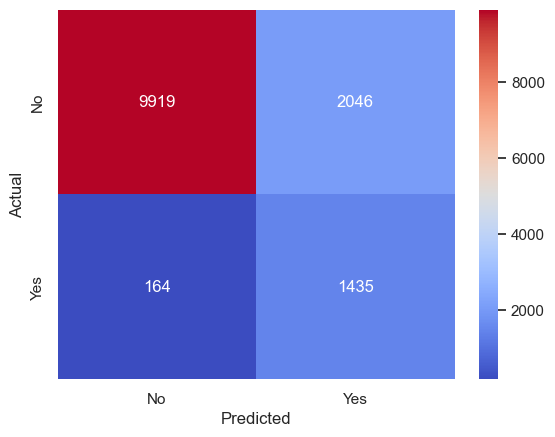

In [60]:
best_balanced_rf = BalancedRandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    max_features=best_max_features,
    sampling_strategy='auto',
    replacement=False,
    bootstrap=True,
    random_state=42
)

best_balanced_rf.fit(X_train, y_train)
y_pred_best_balanced_rf = best_balanced_rf.predict(X_test)
y_pred_best_prob_balanced_rf = best_balanced_rf.predict_proba(X_test)[:, 1]

print("ROC Score: {}%".format(roc_auc(y_test, y_pred_best_balanced_rf)))
plot_confusion_matrix(y_test, y_pred_best_balanced_rf);

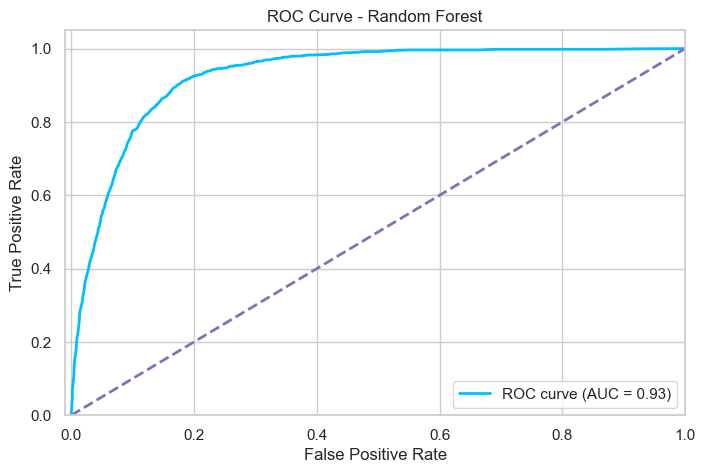

In [61]:
plot_roc_curve(
    y_test=y_test, 
    y_pred_prob=y_pred_best_prob_balanced_rf, 
    model_name="Random Forest"
)

In [62]:
brf_performance = performance(
    y_true=y_test, 
    y_pred=y_pred_best_balanced_rf, 
    model_name='Balanced Random Forest'
)

#### 5.5. Gradient Boosting 

Gradient Boosting is another ensemble learning method that builds models sequentially, with each model correcting the errors of its predecessor. By combining multiple decision trees, it aims to create a strong predictive model.

Although both Gradient Boosting and Random Forest use multiple decision trees, their approaches differ:

- Gradient Boosting builds trees sequentially, with each new tree focusing on correcting the errors of the previous ones by learning from the residuals. It uses gradient descent to minimize the loss function, combining many weak learners to form a strong model.
  
- Random Forest, on the other hand, builds trees independently and in parallel. Each tree is trained on a random subset of the data and features, and the final prediction is made by averaging the predictions of all trees (for regression) or by majority voting (for classification).

Random Forest's parallel approach helps reduce overfitting and variance, making it more robust, while Gradient Boosting tends to be more accurate but can be more sensitive to overfitting, requiring careful hyperparameter tuning.

In [63]:
def optimise_gradient_boosting(n_estimators, learning_rate, max_depth, min_samples_split, max_features):
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    max_features = float(max_features)
    learning_rate = float(learning_rate)
    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        max_features=max_features,
        random_state=42
    )
    scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=3)    
    return scores.mean()

In [64]:
param_space = {
    'n_estimators': (50, 300),        # Number of boosting stages
    'learning_rate': (0.01, 0.3),     # Step size shrinkage
    'max_depth': (3, 20),             # Maximum depth of individual trees
    'min_samples_split': (2, 20),     # Minimum number of samples required to split a node
    'max_features': (0.1, 1.0)        # Proportion of features to consider for splits
}


optimiser = BayesianOptimization(
    f=optimise_gradient_boosting,
    pbounds=param_space,
    random_state=42,
    verbose=2
)
optimiser.maximize(init_points=5, n_iter=5)
best_params_gb = optimiser.max['params']
best_n_estimators_gb = int(best_params_gb['n_estimators'])
best_max_depth_gb = int(best_params_gb['max_depth'])
best_min_samples_split_gb = int(best_params_gb['min_samples_split'])
best_max_features_gb = float(best_params_gb['max_features'])
best_learning_rate_gb = float(best_params_gb['learning_rate'])

print(f"Best Parameters: n_estimators={best_n_estimators_gb}, max_depth={best_max_depth_gb}, "
      f"min_samples_split={best_min_samples_split_gb}, max_features={best_max_features_gb}, learning_rate={best_learning_rate_gb}")

|   iter    |  target   | learni... | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 0.9221    | 0.1186    | 19.16     | 0.7588    | 12.78     | 89.0      |
| 2         | 0.9229    | 0.05524   | 3.987     | 0.8796    | 12.82     | 227.0     |
| 3         | 0.9021    | 0.01597   | 19.49     | 0.8492    | 5.822     | 95.46     |
| 4         | 0.9282    | 0.06319   | 8.172     | 0.5723    | 9.775     | 122.8     |
| 5         | 0.9273    | 0.1874    | 5.371     | 0.3629    | 8.595     | 164.0     |
| 6         | 0.9156    | 0.3       | 8.415     | 0.8154    | 10.02     | 123.1     |
| 7         | 0.9251    | 0.1609    | 6.429     | 0.4752    | 13.19     | 270.4     |
| 8         | 0.9163    | 0.05652   | 18.41     | 0.9601    | 6.766     | 204.2     |
| 9         | 0.9279    | 0.05581   | 5.121     | 0.8194    | 3.73      | 176.4     |
| 10        | 0.915     | 0.2555    | 10.85     | 0.15

ROC Score: 83.91%


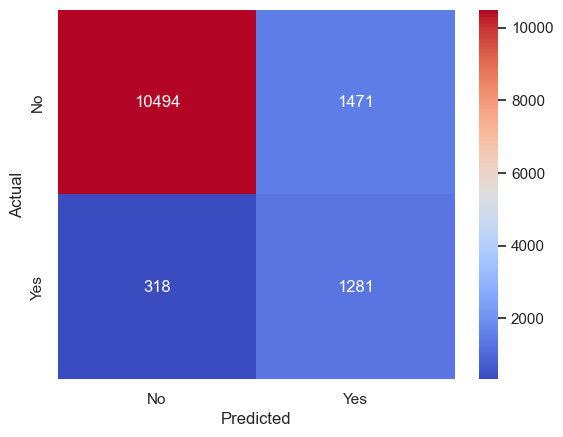

In [65]:
best_model_gb = GradientBoostingClassifier(
    n_estimators=best_n_estimators_gb,
    learning_rate=best_learning_rate_gb,
    max_depth=best_max_depth_gb,
    min_samples_split=best_min_samples_split_gb,
    max_features=best_max_features_gb,
    random_state=42
)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
best_model_gb.fit(X_train, y_train, sample_weight=sample_weights)
y_pred_best_gb = best_model_gb.predict(X_test)
y_pred_prob_best_gb = best_model_gb.predict_proba(X_test)[:, 1]

print("ROC Score: {}%".format(roc_auc(y_test, y_pred_best_gb)))
plot_confusion_matrix(y_test, y_pred_best_gb);

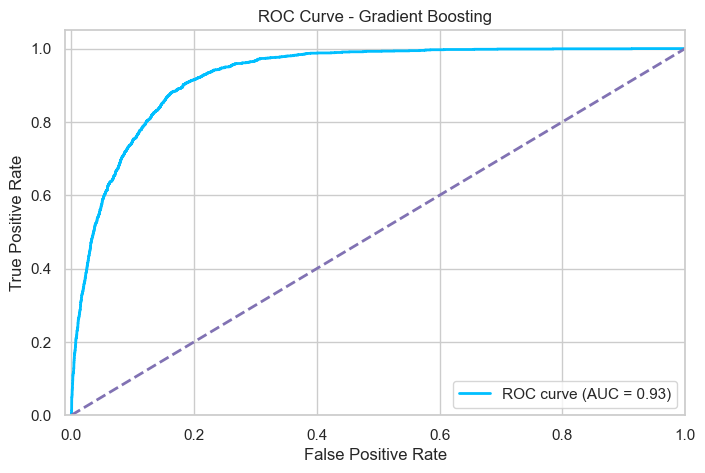

In [66]:
plot_roc_curve(
    y_test=y_test, 
    y_pred_prob=y_pred_prob_best_gb, 
    model_name="Gradient Boosting"
)

In [67]:
gb_performance = performance(
    y_true=y_test, 
    y_pred=y_pred_best_gb, 
    model_name='Gradient Boosting'
)

#### 5.6. XGBoost

Next, we will use XGBoost (Extreme Gradient Boosting) due to its high performance, efficiency, and ability to handle imbalanced datasets. XGBoost aims to improve on traditional Gradient Boosting by adding regularisation to prevent overfitting and offering faster training on large datasets. It also provides advanced features like handling missing values, optimising for speed and accuracy, and flexible hyperparameter tuning. Additionally, XGBoost’s `scale_pos_weight` parameter adjusts for class imbalance, making it ideal for tasks like predicting customer behavior in imbalanced datasets.

In [68]:
def optimise_xgboost(n_estimators, learning_rate, max_depth, min_child_weight, gamma, subsample, colsample_bytree, scale_pos_weight):
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_child_weight = int(min_child_weight)
    model = XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        scale_pos_weight=scale_pos_weight,
        objective='binary:logistic',
        random_state=42,
        eval_metric='logloss'
    )
    scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=3)
    return scores.mean()


param_space = {
    'n_estimators': (50, 300),        # Number of boosting rounds
    'learning_rate': (0.01, 0.3),     # Learning rate (step size shrinkage)
    'max_depth': (3, 15),             # Maximum tree depth
    'min_child_weight': (1, 10),      # Minimum sum of instance weight (Hessian) needed in a child
    'gamma': (0, 0.5),                # Minimum loss reduction required to make a further partition
    'subsample': (0.5, 1.0),          # Subsample ratio of the training instances
    'colsample_bytree': (0.5, 1.0),   # Subsample ratio of columns when constructing each tree
    'scale_pos_weight': (1, 10)       # Balancing weight for imbalanced classes
}


optimiser = BayesianOptimization(
    f=optimise_xgboost,
    pbounds=param_space,
    random_state=42,
    verbose=2
)

optimiser.maximize(init_points=5, n_iter=5)
best_params_xgb = optimiser.max['params']
best_n_estimators_xgb = int(best_params_xgb['n_estimators'])
best_max_depth_xgb = int(best_params_xgb['max_depth'])
best_min_child_weight_xgb = int(best_params_xgb['min_child_weight'])
best_gamma_xgb = float(best_params_xgb['gamma'])
best_subsample_xgb = float(best_params_xgb['subsample'])
best_colsample_bytree_xgb = float(best_params_xgb['colsample_bytree'])
best_learning_rate_xgb = float(best_params_xgb['learning_rate'])
best_scale_pos_weight_xgb = float(best_params_xgb['scale_pos_weight'])

print(f"Best Parameters: n_estimators={best_n_estimators_xgb}, max_depth={best_max_depth_xgb}, "
      f"min_child_weight={best_min_child_weight_xgb}, gamma={best_gamma_xgb}, "
      f"subsample={best_subsample_xgb}, colsample_bytree={best_colsample_bytree_xgb}, "
      f"learning_rate={best_learning_rate_xgb}, scale_pos_weight={best_scale_pos_weight_xgb}")

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.924     | 0.6873    | 0.4754    | 0.2223    | 10.18     | 2.404     | 89.0      | 1.523     | 0.9331    |
| 2         | 0.9263    | 0.8006    | 0.354     | 0.01597   | 14.64     | 8.492     | 103.1     | 2.636     | 0.5917    |
| 3         | 0.9274    | 0.6521    | 0.2624    | 0.1353    | 6.495     | 6.507     | 84.87     | 3.629     | 0.6832    |
| 4         | 0.9274    | 0.728     | 0.3926    | 0.06791   | 9.171     | 6.332     | 61.61     | 6.468     | 0.5853    |
| 5         | 0.9151    | 0.5325    | 0.4744    | 0.29      | 12.7      | 3.742     | 74.42     | 7.158     | 0.7201    |
| 6         | 0.928     | 0.6822    | 0.2924    | 0.1653    | 6.525     | 6.537     | 84.9      | 3.659     | 0.7132    |
| 7         | 0.924     

ROC Score: 85.53%


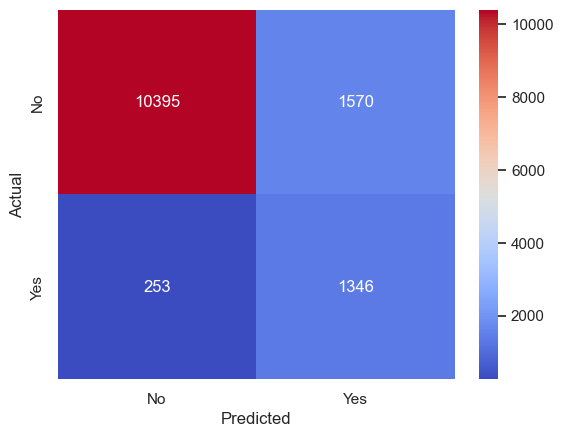

In [69]:
best_xgb = XGBClassifier(
    n_estimators=best_n_estimators_xgb,
    learning_rate=best_learning_rate_xgb,
    max_depth=best_max_depth_xgb,
    min_child_weight=best_min_child_weight_xgb,
    gamma=best_gamma_xgb,
    subsample=best_subsample_xgb,
    colsample_bytree=best_colsample_bytree_xgb,
    scale_pos_weight=best_scale_pos_weight_xgb,
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss'
)


best_xgb.fit(X_train, y_train)
y_pred_best_xgb = best_xgb.predict(X_test)
y_pred_prob_best_xgb = best_xgb.predict_proba(X_test)[:, 1]

print("ROC Score: {}%".format(roc_auc(y_test, y_pred_best_xgb)))
plot_confusion_matrix(y_test, y_pred_best_xgb);

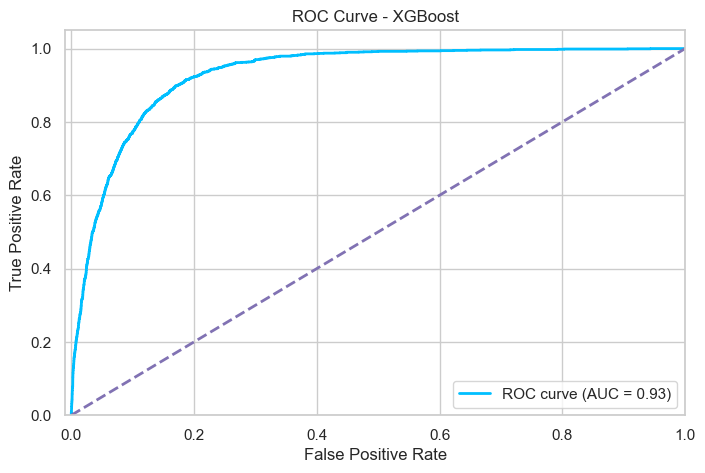

In [70]:
plot_roc_curve(
    y_test=y_test, 
    y_pred_prob=y_pred_prob_best_xgb, 
    model_name="XGBoost"
)

In [71]:
xg_performance = performance(
    y_true=y_test, 
    y_pred=y_pred_best_xgb, 
    model_name='XGBoost'
)

#### 5.6. Neural Networks 

Lastly, we will use neural networks to predict term deposit subscriptions. These models excel at handling large datasets with complex feature interactions but require more computational resources and longer training times than simpler classifiers.

To prepare for this, we need to format the training set appropriately. We'll use Keras to build the model, which requires the data to be in numpy array format for efficient processing. Additionally, we’ll convert the labels to one-hot encoding to enable the network to output class probabilities.

In [72]:
x_nn_train = X_train.to_numpy().astype('float32')
x_nn_test = X_test.to_numpy().astype('float32')
y_nn_train = to_categorical(y_train, 2)
y_nn_test = to_categorical(y_test, 2)

Here we create the neural network model using the Keras framework.

In [73]:
def create_model(learning_rate=0.001, optimiser='adam', dropout_rate=0.0):
    model = Sequential()
    model.add(Input(shape=(x_nn_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['accuracy'])
    return model

As with the previous models, we'll use Bayesian Optimisation to fine-tune the hyperparameters.

In [74]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

def optimise_neural_network(learning_rate, dropout_rate):
    learning_rate = float(learning_rate)
    dropout_rate = float(dropout_rate)
    model = KerasClassifier(
        model=create_model,
        learning_rate=learning_rate,
        optimizer='adam',
        dropout_rate=dropout_rate,
        batch_size=32,
        epochs=10,
        verbose=0
    )
    scores = cross_val_score(model, x_nn_train, y_nn_train, cv=3, scoring='accuracy', params={'class_weight': class_weights_dict})
    return scores.mean()


param_space = {
    'learning_rate': (0.0001, 0.01),
    'dropout_rate': (0.0, 0.5)
}

optimiser = BayesianOptimization(
    f=optimise_neural_network,
    pbounds=param_space,
    random_state=42,
    verbose=2
)

optimiser.maximize(init_points=5, n_iter=15)
best_params_nn = optimiser.max['params']
best_learning_rate = best_params_nn['learning_rate']
best_dropout_rate = best_params_nn['dropout_rate']

print(f"Best Parameters: learning_rate={best_learning_rate}, dropout_rate={best_dropout_rate}")

|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
| 1         | 0.7392    | 0.1873    | 0.009512  |
| 2         | 0.7254    | 0.366     | 0.006027  |
| 3         | 0.7829    | 0.07801   | 0.001644  |
| 4         | 0.7984    | 0.02904   | 0.008675  |
| 5         | 0.7271    | 0.3006    | 0.00711   |
| 6         | 0.8257    | 0.0       | 0.0001    |
| 7         | 0.7236    | 0.5       | 0.0001    |
| 8         | 0.8031    | 0.0       | 0.01      |
| 9         | 0.7099    | 0.4324    | 0.002265  |
| 10        | 0.7831    | 0.1254    | 0.0001    |
| 11        | 0.7899    | 0.07799   | 0.001646  |
| 12        | 0.7979    | 0.02919   | 0.0086    |
| 13        | 0.825     | 9.016e-05 | 0.000219  |
| 14        | 0.8279    | 0.0002468 | 0.0001    |
| 15        | 0.8136    | 0.0004154 | 0.0003422 |
| 16        | 0.7757    | 0.07765   | 0.001671  |
| 17        | 0.8237    | 4.976e-05 | 0.009651  |
| 18        | 0.8206    | 0.02929   | 0.009006  |


In [75]:
best_nn = KerasClassifier(
    model=create_model,
    learning_rate=best_learning_rate,
    optimizer='adam',
    dropout_rate=best_dropout_rate,
    batch_size=32,
    epochs=10,
    verbose=1
)


best_nn.fit(x_nn_train, y_nn_train, class_weight=class_weights_dict)
y_pred_best_nn = best_nn.predict(x_nn_test)
y_pred_best_prob_nn = best_nn.predict_proba(x_nn_test)[:, 1]
print("ROC Score: {}%".format(roc_auc(y_nn_test, y_pred_best_nn)))

Epoch 1/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7447 - loss: 0.6229
Epoch 2/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7700 - loss: 0.4206
Epoch 3/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7882 - loss: 0.3956
Epoch 4/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8023 - loss: 0.3793
Epoch 5/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8066 - loss: 0.3671
Epoch 6/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8161 - loss: 0.3618
Epoch 7/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8075 - loss: 0.3598
Epoch 8/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8115 - loss: 0.3536
Epoch 9/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8188 - loss: 0.3455
Epoch 10/10
989/989 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8191 - loss: 0.3342
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
ROC Score: 83.84%


Since we used one-hot encoding, convert `y_nn_test` and `y_pred_best_nn` back to integer labels to plot the confusion matrix.

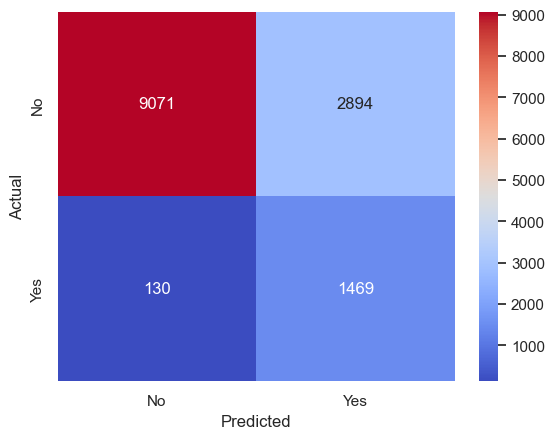

In [76]:
y_test_labels = np.argmax(y_nn_test, axis=1)
y_pred_labels = np.argmax(y_pred_best_nn, axis=1) 
plot_confusion_matrix(y_test_labels, y_pred_labels)

In [77]:
nn_performance = performance(
    y_true=y_nn_test, 
    y_pred=y_pred_best_nn, 
    model_name='Neural Network'
)

### 6. Model evaluation

#### 6.1. Measures of performance

In this section, we will evaluate the performance of our prediction models by considering more metrics beyond the ROC-AUC score. Incorporating accuracy, precision, recall, and F1 score into our analysis will provide a deeper understanding of the model's effectiveness in identifying customers likely to subscribe to a term deposit, while balancing the trade-offs between different types of prediction errors. By analysing these metrics, we aim to ensure that our model is not only accurate but also practical for guiding targeted marketing actions and decision-making.

##### ROC-AUC score

As we've already seen, the ROC-AUC score measures the model's ability to distinguish between classes by evaluating the area under the Receiver Operating Characteristic (ROC) curve. It reflects the trade-off between the true positive rate (recall) and the false positive rate across different threshold settings. A perfect classifier would have an ROC-AUC score of 1, while a score of 0.5 suggests the model is no better than random guessing.

##### Accuracy

Accuracy measures the overall correctness of the model by calculating the ratio of correctly predicted instances (both subscribers and non-subscribers) to the total number of instances. While accuracy provides a general idea of the model's performance, it can be misleading in slightly imbalanced datasets like this one, where non-subscribers outnumber subscribers, as it may overestimate the model's effectiveness.

$$\text{Accuracy}=\frac{TP+TN}{TP+TN+FP+FN}$$

##### Precision

Precision measures the accuracy of the positive predictions by calculating the ratio of true positives to the total predicted positives. In our task, precision indicates how many of the customers predicted to subscribe actually went on to subscribe.

$$\text{Precision}=\frac{TP}{TP+FP}$$

High precision is important when the cost of incorrectly predicting that a customer will subscribe (false positive) is high. For example, if the bank invests resources in targeting customers predicted to subscribe but who ultimately don't, it could lead to wasted marketing efforts, increased costs, and inefficient allocation of resources.

##### Recall

Recall, also known as sensitivity or the true positive rate, measures the model's ability to identify all actual positive instances (subscribers). It reflects how effectively the model captures all customers who are likely to subscribe.

$$\text{Recall}=\frac{TP}{TP+FN}$$

High recall ensures that most customers who are likely to subscribe are identified, which is important for increasing subscription rates by enabling proactive measures. For example, the bank can focus its efforts on following up with potential subscribers, maximizing the chances of conversion and reducing missed opportunities.

##### F1 Score

The F1 Score is the harmonic mean of precision and recall, offering a balanced metric that takes both into account. It is particularly useful in cases of imbalanced class distributions, as it provides a more meaningful evaluation than accuracy alone. By combining precision and recall, the F1 Score ensures that the model maintains a good balance between correctly identifying true subscribers while minimising false positives.

$$\text{F1 Score}=2 \times \frac{(\text{Precision}\times\text{Recall})}{(\text{Precision}+\text{Recall})}$$

#### 6.2. Model selection

Now that we have a clear understanding of the performance metrics we are using, we will proceed to compare the performance of the various machine learning models we trained and tested in the previous section. Our goal is to select the best model for predicting whether a customer will subscribe to a term deposit in the bank marketing campaign, based on the model's ability to handle class imbalance and accurately predict the target outcome.

In [78]:
performance_list = [
    lr_performance,
    rf_performance,
    brf_performance,
    gb_performance,
    xg_performance,
    nn_performance
]

performance_df = pd.DataFrame(performance_list)
performance_df_sorted = performance_df.sort_values(by='ROC-AUC Score', ascending=False)
performance_df_sorted

,Algorithm,ROC-AUC Score,Accuracy,Precision,Recall,F1 Score
2,Balanced Random Forest,86.32,83.71,91.64,83.71,86.03
4,XGBoost,85.53,86.56,91.56,86.56,88.13
3,Gradient Boosting,83.91,86.81,91.10,86.81,88.22
5,Neural Network,83.84,77.71,90.93,77.71,81.42
0,Logistic Regression,82.73,84.34,90.49,84.34,86.32
1,Random Forest,73.28,90.58,89.89,90.58,90.15


We observe that most of the models performed relatively well in predicting whether a customer will subscribe to a term deposit, which indicates that the dataset has significant predictive features for this task. This is consistent with the insights gathered from our exploratory data analysis, where key factors like duration, job type, and previous campaign outcomes showed clear patterns related to customer behavior.

Among the models, XGBoost delivered the best overall performance. It provided a solid balance between accuracy, precision, and recall. XGBoost showed the highest ROC-AUC score, indicating its ability to distinguish between customers who will and won’t subscribe. Its precision was slightly better than other models, meaning that a good proportion of its positive predictions were correct. The recall score was effective in identifying a large portion of likely subscribers, which makes it a strong candidate for this task. The F1 score confirms that XGBoost managed a reasonable trade-off between precision and recall.

Balanced Random Forest followed closely behind XGBoost, showing comparable performance in terms of accuracy and recall, though with slightly lower precision. This suggests that while it was good at capturing subscribers, it might have predicted more false positives compared to XGBoost. Nonetheless, Random Forest’s ensemble nature still makes it a robust choice, particularly if model interpretability or resistance to overfitting is a key concern.

Other models, such as Neural Networks, Logistic Regression and "regular" Random Forest, demonstrated decent but slightly lower performance. Neural Networks, despite their ability to model complex patterns, did not outperform XGBoost or Random Forest, and its added complexity may not justify its use in this case. Logistic Regression, while easier to interpret, struggled to capture more nuanced patterns in the data, as reflected in its lower performance metrics.

In summary, we selected XGBoost as the model for predicting customer subscriptions in the bank marketing campaign. While no model provides perfect predictions, XGBoost offered the best balance of precision, recall, and ROC-AUC. Its ability to effectively handle imbalanced data and consistently perform well across key metrics makes it the most suitable choice based on our evaluation.

Next, we will conduct a feature importance analysis to identify the key features contributing to its predictions. This step helps refine the model by potentially reducing complexity and enhancing interpretability, ensuring that only the most relevant features are used to predict customer behaviour. Additionally, feature importance analysis can reveal which factors most influence customer subscriptions, offering valuable insights for future marketing strategies.

#### 6.3. Feature importance

In this section, we will conduct a feature importance analysis to identify which predictors contribute the most to the model's performance in predicting customer subscription. By understanding the relative importance of each feature, we can gain insights into the key factors driving the model's predictions and potentially simplify the model for better interpretability and efficiency.

In [79]:
importance_values = best_xgb.get_booster().get_score(importance_type='weight')

feature_importance_df = pd.DataFrame({
    'Feature': [X.columns[int(feat[1:])] if feat[1:].isdigit() else feat for feat in importance_values.keys()],
    'Importance': list(importance_values.values())
})

feature_importance_df['Importance'] = feature_importance_df['Importance'] / feature_importance_df['Importance'].sum()
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df.head()

,Feature,Importance
1,balance,0.159824
3,duration,0.144023
0,age,0.141951
2,day_of_week,0.137936
5,pdays,0.072400


We calculate the cumulative importance of the features to assess their combined contribution, identifying the features that together account for 80% of the model's total importance.

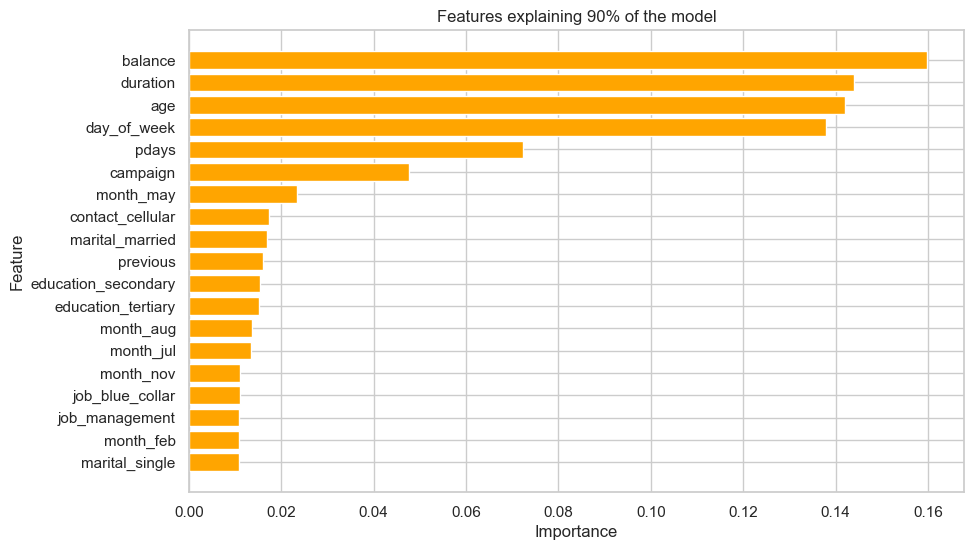

In [80]:
feature_importance_df['Cumulative Importance'] = feature_importance_df['Importance'].cumsum()
important_features_80 = feature_importance_df[feature_importance_df['Cumulative Importance'] <= 0.90]

plt.figure(figsize=(10, 6))
plt.barh(important_features_80['Feature'], important_features_80['Importance'], color='orange')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Features explaining 90% of the model')
plt.gca().invert_yaxis()
plt.show();

Identifying the most influential features helps us understand the key patterns and factors driving the model's predictions. The top three features are `balance`, `duration`, and `age`, indicating that a customer’s account balance, the length of their previous interaction with the bank, and their age are highly relevant in determining the likelihood of subscription.

Interestingly (but in line with what we observed during EDA), `day_of_week` and `pdays` (number of days since the customer was last contacted) also play notable roles, suggesting that the timing and frequency of previous engagements have a significant impact. 

Other features like campaign, `contact method` (cellular), and specific `month` (May) further underscore how customer interaction channels and the timing of marketing efforts can influence outcomes. These insights can help tailor future marketing campaigns by prioritising customer segments based on their balance, age, and past interaction behaviour (more on actionable insights in the next section).

This analysis not only improves the model's interpretability but also helps us focus on the most important data, potentially simplifying the model and boosting its performance. Next, we will apply this by retraining our XGBoost model using only the top features identified above

In [81]:
features_of_interest = important_features_80['Feature'].to_list()
X_train_top_features = X_train[features_of_interest].copy()
X_test_top_features = X_test[features_of_interest].copy()

print("Number of features in the original dataset:", X_train.shape[1])
print("Number of features in the reduced dataset:", X_train_top_features.shape[1])

best_xgb.fit(X_train_top_features, y_train)
y_pred_best_xgb_reduced = best_xgb.predict(X_test_top_features)
y_pred_prob_best_xgb_reduced = best_xgb.predict_proba(X_test_top_features)[:, 1]

Number of features in the original dataset: 42
Number of features in the reduced dataset: 19


In [82]:
xg_reduced_performance = performance(
    y_true=y_test, 
    y_pred=y_pred_best_xgb_reduced, 
    model_name='Reduced XGBoost'
)

xg_reduced_performance = pd.DataFrame([xg_reduced_performance])
xg_reduced_performance

,Algorithm,ROC-AUC Score,Accuracy,Precision,Recall,F1 Score
0,Reduced XGBoost,84.27,85.77,91.09,85.77,87.47


Running XGBoost on the reduced dataset, using only the top features, results in decent performance, with a ROC-AUC score of 84.27% and an accuracy of 85.77%. While this is slightly lower than the performance achieved using the full feature set, it still demonstrates that the most important features capture much of the predictive power. 

Although it's recommend to retain the full dataset in this instance, this exercise underscores the importance of feature selection, especially when working with large datasets or limited computing resources. Reducing the number of features can significantly cut down on computational costs, speed up model training, and simplify interpretation, all without greatly affecting accuracy or predictive power.

#### 6.4. Further insights

Based on all the analysis we've done so far, several key insights can guide the marketing team in developing strategies to increase subscription rates for the bank's term deposit campaign. The top contributing features, such as balance, duration, and age, reveal that customer financial stability, engagement with the campaign, and demographics play critical roles in determining whether someone subscribes.

The marketing team should prioritise targeting customers with higher account balances, as these individuals are more likely to have the financial flexibility to invest in a term deposit. Additionally, the length of previous interactions (duration) suggests that longer and more meaningful conversations during campaigns increase the likelihood of subscription.

Recommendations for improving subscription rates based on these insights include:

| Feature | Recommendation | Explanation |
| --- | --- | --- |
| Balance | Target high-balance customers |  Since balance is a leading predictor of term deposit subscriptions, the marketing team should focus efforts on customers with higher account balances. Personalised offers or incentives aimed at these customers could help increase conversions. These customers may already have the financial stability to invest, making them prime candidates for the campaign. |
| Duration | Enhance interaction quality | The duration of conversations strongly influences customer decisions. The marketing team should train agents to engage customers in more meaningful, longer discussions, focusing on the benefits of the term deposit product and addressing specific customer needs. Improving the quality of interactions, rather than simply increasing the volume of calls, can have a substantial impact. |
| Contact method | Prioritise direct and personal communication | Customers contacted via cellular channels are more likely to respond positively, suggesting that direct and personal communication works better than more passive methods. |
| Timing | Release campaigns on high-conversion dates | Certain months and days, such as May and specific days of the week, show higher conversion rates, indicating that campaign timing plays a role in its effectiveness. The marketing team should focus on running their campaigns during these optimal periods and using direct communication methods to increase the chances of success. |
| Age | Leverage customer demographics | The model highlights age as an important factor, and based on our previous analysis we noticed that slightly older customers are more likely to subscribe. Marketing efforts can be segmented based on age groups, with tailored messaging that resonates with different life stages. For example, older customers may be more interested in safe, long-term investments like term deposits, while younger customers may need additional incentives to consider this option. |

By aligning campaign strategies with the insights from data analysis and our model insights, the marketing team can more effectively allocate resources, improve customer engagement, and ultimately boost subscription rates for the bank's term deposit offerings.

### 7. Save model for deployment

When preparing a machine learning model for real-world use, it's important to ensure that the model can be easily reused without retraining it every time. By saving the trained model, we can apply it to new data in production environments, enabling consistent and efficient predictions without repeating the training process. Saving the model preserves the hyperparameters and learned patterns, ensuring that the model behaves exactly as expected when deployed.

To save our selected model for future use and potential deployment, we will use the `joblib` library. This library is optimised for handling large numpy arrays and can efficiently save complex models, making it ideal for our needs.

In [88]:
model_filename = 'model/best_xgb.joblib'
joblib.dump(best_xgb, model_filename)

print(f"Model saved to {model_filename}")

Model saved to model/best_xgb.joblib


The load function is used to deserialise the model from the saved file, allowing you to reload it into your application for future use. We'll use the loaded model to make predictions and verify that it was loaded correctly and performs as expected.

In [89]:
loaded_xg_model = joblib.load('model/best_xgb.joblib')

loaded_xg_model.fit(X_train, y_train)
y_pred_loaded = loaded_xg_model.predict(X_test)
original_score = xg_performance['ROC-AUC Score']
loaded_score = roc_auc(y_test, y_pred_loaded)

assert original_score == loaded_score

This approach allows your model to be saved, loaded, and reused efficiently, making it easy to deploy in production environments. Once deployed, the model can be integrated into applications to automate predictions and continuously support decision-making without needing to retrain it every time. 

For instance, our XGBoost model trained to predict term deposit subscriptions can be used in real-world scenarios to assess whether new or existing customers are likely to subscribe. This could be integrated into customer management systems, enabling marketing teams to target their outreach efforts more effectively, personalise offers, and optimise marketing strategies in real time based on the model's predictions.

### 8. References

- [Bank Marketing Dataset](https://archive.ics.uci.edu/dataset/222/bank+marketing)
- [Hyperparameter Tuning the Random Forest in Python](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)
- [Random Forest: A Complete Guide for Machine Learning](https://builtin.com/data-science/random-forest-algorithm)
- [Gradient Boosting In Classification: Not a Black Box Anymore!](https://www.digitalocean.com/community/tutorials/gradient-boosting-for-classification)
- [Gradient Boosting in Python from Scratch](https://towardsdatascience.com/gradient-boosting-in-python-from-scratch-788d1cf1ca7)
- [Mastering XGBoost: A Technical Guide for Machine Learning Practitioners](https://medium.com/@jyotsna.a.choudhary/mastering-xgboost-a-technical-guide-for-intermediate-machine-learning-practitioners-f7ad167c6865)
- [Using XGBoost in Python](https://www.datacamp.com/tutorial/xgboost-in-python)
- [Python AI: How to Build a Neural Network & Make Predictions](https://realpython.com/python-ai-neural-network/)
- [Neural Networks 101: Hands-on practice](https://medium.com/@ja_adimi/neural-networks-101-hands-on-practice-25df515e13b0)
- [Exploring Machine Learning Models: A Comprehensive Comparison of Logistic Regression, Decision Trees, SVM, Random Forest, and XGBoost](https://medium.com/@ja_adimi/neural-networks-101-hands-on-practice-25df515e13b0)
- [XGBoost Parameters Tuning: A Complete Guide with Python Codes](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
- [Calculating XGBoost Feature Importance](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5#:~:text=ROC%20is%20a%20probability%20curve,and%201%20classes%20as%201.)
- [How to Implement Bayesian Optimization from Scratch in Python](https://machinelearningmastery.com/what-is-bayesian-optimization/)
- [Mastering Bayesian Optimization in Data Science](https://www.datacamp.com/tutorial/mastering-bayesian-optimization-in-data-science)
- [Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5#:~:text=ROC%20is%20a%20probability%20curve,and%201%20classes%20as%201.)
- [How to Save Trained Model in Python](https://neptune.ai/blog/saving-trained-model-in-python)